In [1]:
import numpy as np
import polars as pl
import plotnine as p9
from scipy.signal import convolve
from tqdm.notebook import tqdm
from scipy.fft import fft, fftfreq, ifft

In [ ]:
# Parameters
fs = 4800  # Hz
duration = 1.0  # seconds
t = np.linspace(0, duration, int(fs * duration))
N = 20 # number of motor units
tau = 0.005  # twitch decay constant
central_frequency = 80  # Hz
tikhonov_lambda = 1e2  # Tikhonov regularization parameter

In [3]:
# Functions
def generate_spike_train(rate, duration, jitter=0.001, fs=4800):
    isi = np.random.normal(1/rate, jitter, size=int(rate * duration * 2))
    spike_times = np.cumsum(isi)
    spike_times = spike_times[spike_times < duration]
    spike_train = np.zeros(int(fs * duration))
    spike_idx = (spike_times * fs).astype(int)
    spike_train[spike_idx] = 1
    return spike_train

def twitch_kernel(t, tau, alpha=1.0):
    return alpha * t * np.exp(-t / tau)

def normalised_twitch_kernel(t, tau):
    kernel = twitch_kernel(t, tau)
    kernel /= np.sqrt(np.sum(kernel**2) * (t[1] - t[0]))  # Normalization
    return kernel

def convolve_spikes_with_twitch(spike_train, fs=4800, tau=0.005):
    t_kernel = np.arange(0, 0.05, 1/fs)
    kernel = normalised_twitch_kernel(t_kernel, tau)
    return np.convolve(spike_train, kernel, mode='same')


In [4]:
# Generate spike trains and responses
unit_ids = []
timepoints = []
values = []
types = []
spikes = []
rates = []

for i in range(N):
    rate = np.random.normal(central_frequency, 5)
    spike_train = generate_spike_train(rate, duration, jitter=0.001, fs=fs)
    response = convolve_spikes_with_twitch(spike_train, fs=fs, tau=tau)
    unit = f"Unit {i+1}"

    timepoints.extend(t)
    values.extend(response)
    spikes.extend(spike_train)
    unit_ids.extend([unit] * len(t))
    types.extend(["response"] * len(t))
    rates.extend(np.repeat(rate, len(t)))

# Create Polars DataFrame
df_pl = pl.DataFrame({
    "time": timepoints,
    "value": values,
    "spikes": spikes,
    "unit": unit_ids,
    "type": types,
    "rate": rates
})

# Sum across units to get total OMT signal
omt_signal_df = (
    df_pl
    .group_by("time")
    .agg(pl.col("value").sum().alias("value"))
    .with_columns([
        pl.col("value").alias("spikes"),
        pl.lit("Summed").alias("unit"),
        pl.lit("signal").alias("type"),
        pl.lit(float(central_frequency)).alias("rate")
    ]).with_columns([
        pl.col("value") - pl.col("value").mean()  # Center the signal
    ])
)
df_all = pl.concat([df_pl, omt_signal_df])


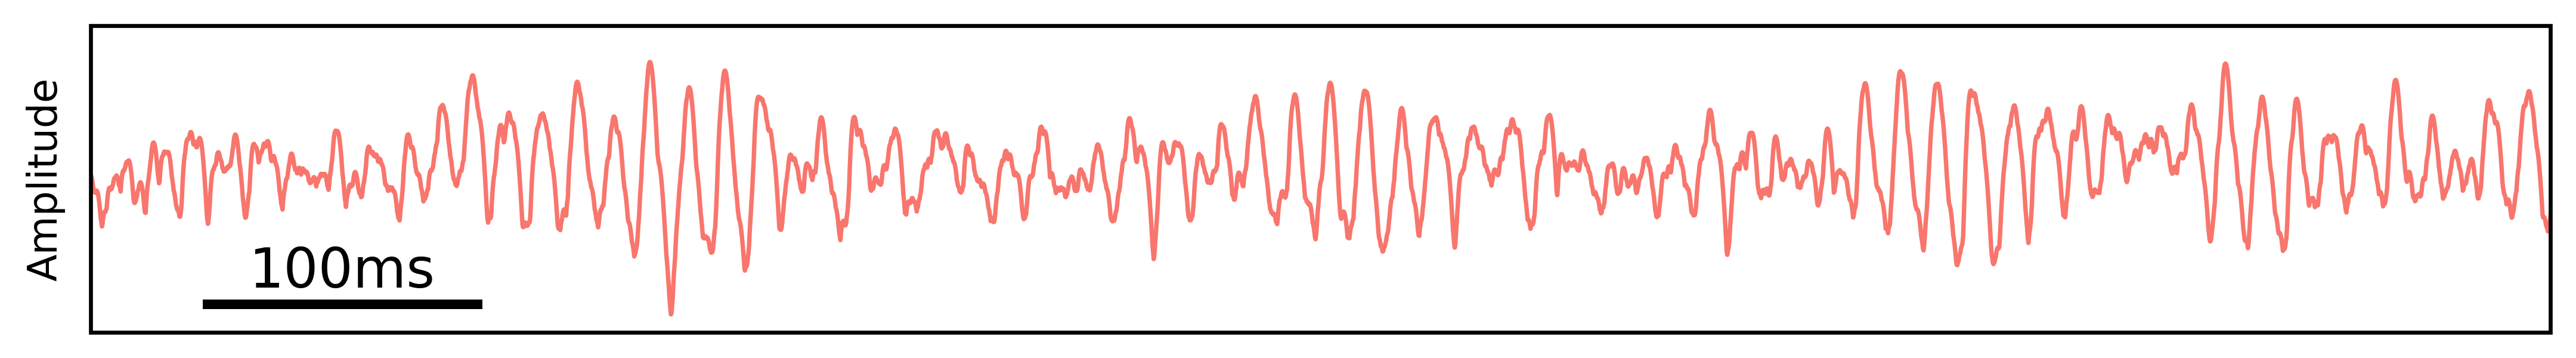

/root/venv/lib/python3.12/site-packages/plotnine/ggplot.py:630: PlotnineWarning: Saving 7.2 x 1.0 in image.
/root/venv/lib/python3.12/site-packages/plotnine/ggplot.py:631: PlotnineWarning: Filename: /workspace/output/figures/omt_signal.png
/root/venv/lib/python3.12/site-packages/plotnine/ggplot.py:630: PlotnineWarning: Saving 7.2 x 1.0 in image.
/root/venv/lib/python3.12/site-packages/plotnine/ggplot.py:631: PlotnineWarning: Filename: /workspace/output/figures/omt_signal.pdf


In [5]:
# Plot using plotnine with facetting by unit
_df_fig_summed = df_all.filter(
    pl.col("unit").is_in(["Summed"])
).with_columns([
    (pl.col("spikes") * 100).alias("spikes")
])
required_units = [f"Unit {i+1}" for i in range(3)]
_df_fig_units = df_all.filter(
    pl.col("unit").is_in(required_units)
).with_columns([
    (pl.col("spikes") * 100).alias("spikes")
])
fig = (
    p9.ggplot(_df_fig_summed, p9.aes(x="time", y="spikes", color="type")) +
    p9.geom_line() +
    p9.geom_line(data=_df_fig_units, alpha=0.2) +
    p9.annotate("rect", xmin=0.1, xmax=0.20, ymin=_df_fig_summed["spikes"].mean() - 1.4 * _df_fig_summed["spikes"].std(), ymax=_df_fig_summed["spikes"].mean() - 1.3 * _df_fig_summed["spikes"].std(), fill="black") +
    p9.annotate("text", x=0.15, y=_df_fig_summed["spikes"].mean() - 1.0 * _df_fig_summed["spikes"].std(), label="100ms", ha="center", color="black") +
    p9.labs(x=False, y="Amplitude") +
    p9.coord_cartesian(ylim=(_df_fig_summed["spikes"].mean() - 1.5 * _df_fig_summed["spikes"].std(), _df_fig_summed["spikes"].mean() + 1.5 * _df_fig_summed["spikes"].std()), xlim=(0.1, 0.9)) +
    p9.theme_matplotlib() +
    p9.guides(color=False, alpha=False) +
    p9.theme(figure_size=(7.2, 1.0), dpi=300, text=p9.element_text(size=8), axis_ticks_x=p9.element_blank(), axis_text_x=p9.element_blank(), axis_text_y=p9.element_blank(), axis_ticks_y=p9.element_blank())
)

fig.show()
fig.save("/workspace/output/figures/omt_signal.png")
fig.save("/workspace/output/figures/omt_signal.pdf")

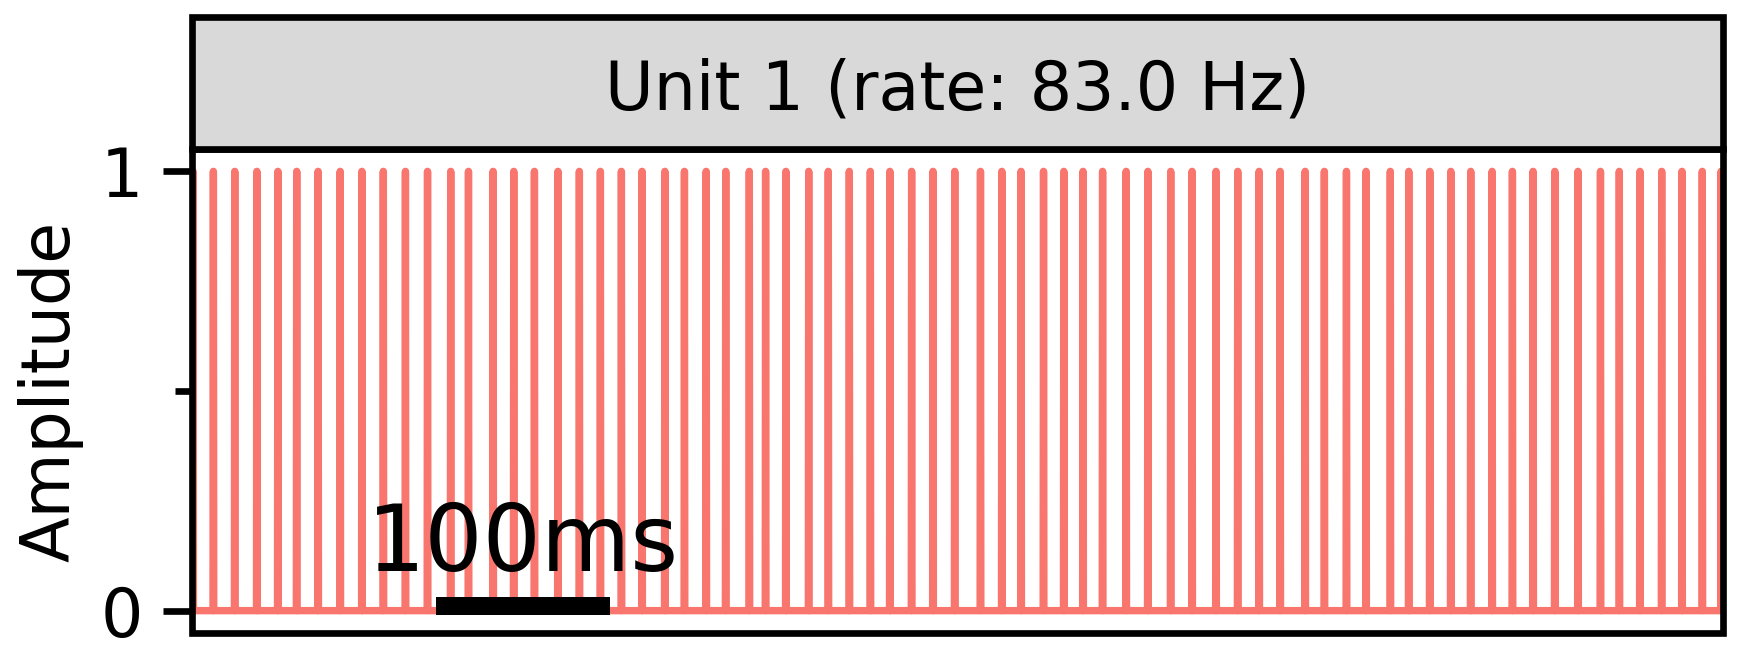

/root/venv/lib/python3.12/site-packages/plotnine/ggplot.py:630: PlotnineWarning: Saving 2.9 x 1.1 in image.
/root/venv/lib/python3.12/site-packages/plotnine/ggplot.py:631: PlotnineWarning: Filename: /workspace/output/figures/omt_signal_spikes.png
/root/venv/lib/python3.12/site-packages/plotnine/ggplot.py:630: PlotnineWarning: Saving 2.9 x 1.1 in image.
/root/venv/lib/python3.12/site-packages/plotnine/ggplot.py:631: PlotnineWarning: Filename: /workspace/output/figures/omt_signal_spikes.pdf


In [6]:
required_units = [f"Unit {i+1}" for i in range(1)]
_df_fig_spikes = df_all.filter(
    pl.col("type").is_in(["response", "signal"])
).filter(
    pl.col("unit").is_in(required_units)
).with_columns([
    pl.concat_str(pl.col("unit"), pl.lit(" (rate: "), pl.col("rate").cast(pl.Float64).round_sig_figs(2).cast(pl.String), pl.lit(" Hz)")).alias("unit_rate")
])
fig_spikes = (
    p9.ggplot(_df_fig_spikes, p9.aes(x="time", y="spikes", color="unit")) +
    p9.geom_line() +
    p9.facet_wrap("unit_rate", ncol=1, scales="free_y") +
    p9.annotate("rect", xmin=0.2, xmax=0.3, ymin=-0.01, ymax=0.03, fill="black") +
    p9.annotate("text", x=0.25, y=0.15, label="100ms", ha="center", color="black") +
    p9.scale_y_continuous(breaks=np.linspace(0, 1, 2)) +
    p9.labs(x=False, y="Amplitude") +
    p9.coord_cartesian(ylim=(0, 1), xlim=(0.1, 0.9)) +
    p9.theme_matplotlib() +
    p9.guides(color=False, alpha=False) +
    p9.theme(figure_size=(2.9, 1.1), dpi=300, text=p9.element_text(size=8), axis_ticks_x=p9.element_blank(), axis_text_x=p9.element_blank())
)
fig_spikes.show()
fig_spikes.save("/workspace/output/figures/omt_signal_spikes.png")
fig_spikes.save("/workspace/output/figures/omt_signal_spikes.pdf")

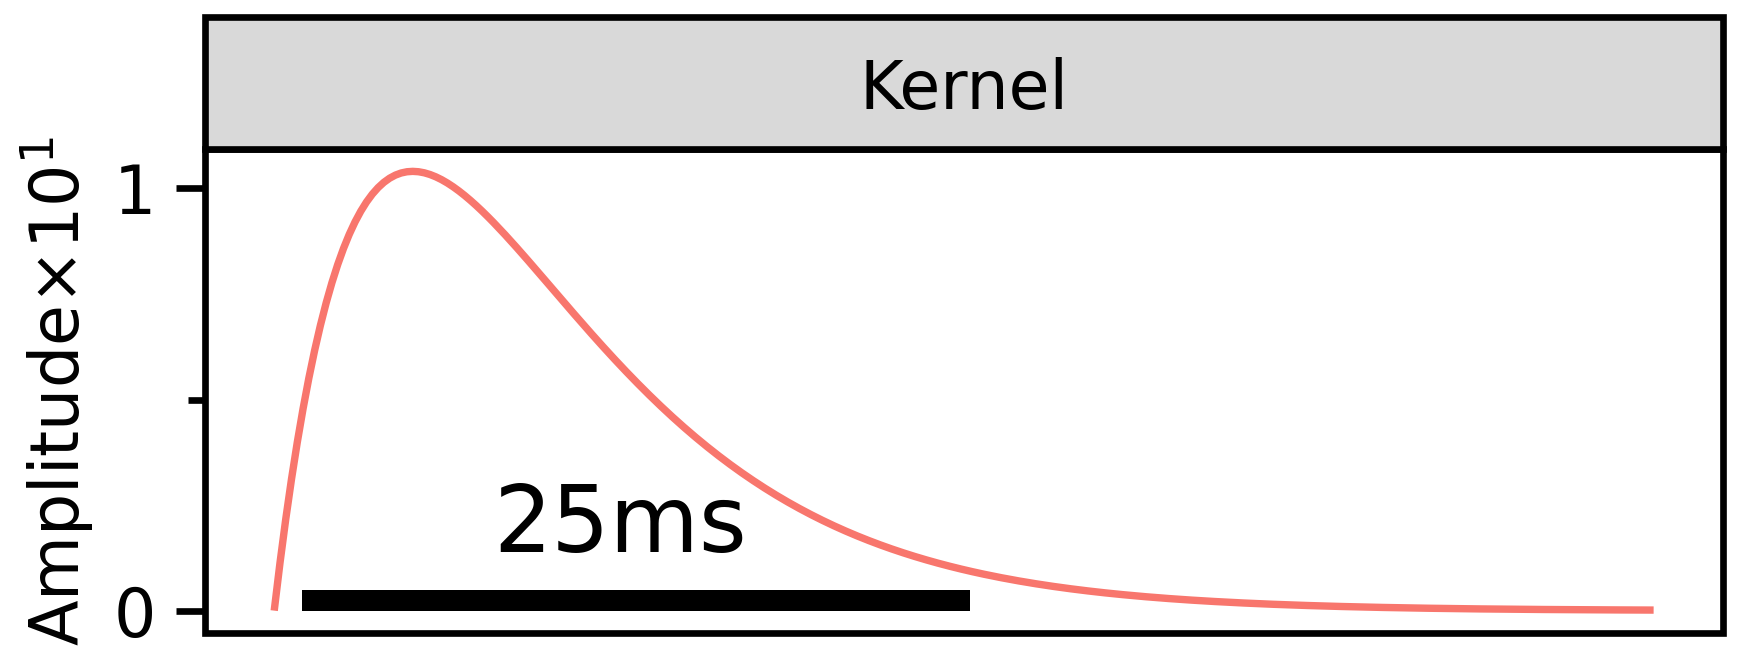

/root/venv/lib/python3.12/site-packages/plotnine/ggplot.py:630: PlotnineWarning: Saving 2.9 x 1.1 in image.
/root/venv/lib/python3.12/site-packages/plotnine/ggplot.py:631: PlotnineWarning: Filename: /workspace/output/figures/omt_signal_kernel.png
/root/venv/lib/python3.12/site-packages/plotnine/ggplot.py:630: PlotnineWarning: Saving 2.9 x 1.1 in image.
/root/venv/lib/python3.12/site-packages/plotnine/ggplot.py:631: PlotnineWarning: Filename: /workspace/output/figures/omt_signal_kernel.pdf


In [7]:
# draw the kernel shape using plotnine
t_kernel = np.arange(0, 0.05, 1/fs)
kernel = normalised_twitch_kernel(t_kernel, tau)
_df_fig_kernel = pl.DataFrame({
    "time": t_kernel,
    "value": kernel / 10,
    "type": "Kernel"
})
fig_kernel = (
    p9.ggplot(_df_fig_kernel, p9.aes(x="time", y="value", color="type")) +
    p9.geom_line() +
    p9.facet_wrap("type", ncol=1, scales="free_y") +
    p9.annotate("rect", xmin=0.001, xmax=0.0251, ymin=0, ymax=0.05, fill="black") +
    p9.annotate("text", x=0.0125, y=0.2, label="25ms", ha="center", color="black") +
    p9.scale_y_continuous(breaks=np.linspace(0, 1, 2)) +
    p9.labs(x=False, y=r"Amplitude$\times10^1$") +
    p9.theme_matplotlib() +
    p9.guides(color=False, alpha=False) +
    p9.theme(figure_size=(2.9, 1.1), dpi=300, text=p9.element_text(size=8), axis_ticks_x=p9.element_blank(), axis_text_x=p9.element_blank())
)
fig_kernel.show()
fig_kernel.save("/workspace/output/figures/omt_signal_kernel.png")
fig_kernel.save("/workspace/output/figures/omt_signal_kernel.pdf")

In [8]:
# draw the fft of the summed OMT signal
omt_signal = df_all.filter(pl.col("type") == "signal").select("value").to_numpy()
omt_fft = np.fft.fft(omt_signal)
freqs = np.fft.fftfreq(len(omt_signal), d=1/fs)

# only plot the positive frequencies
positive_freqs = freqs[freqs >= 0]
positive_magnitude = np.abs(omt_fft[freqs >= 0])

# use plotnine to plot the fft
fft_df = pl.DataFrame({
    "frequency": positive_freqs.tolist(),
    "magnitude": positive_magnitude.flatten().tolist()
})
fft_df


shape: (2_400, 2)
┌───────────┬───────────┐
│ frequency ┆ magnitude │
│ ---       ┆ ---       │
│ f64       ┆ f64       │
╞═══════════╪═══════════╡
│ 0.0       ┆ 9.747634  │
│ 1.0       ┆ 4.946411  │
│ 2.0       ┆ 18.342413 │
│ 3.0       ┆ 0.765043  │
│ 4.0       ┆ 14.54064  │
│ …         ┆ …         │
│ 2395.0    ┆ 10.975235 │
│ 2396.0    ┆ 26.026525 │
│ 2397.0    ┆ 0.349539  │
│ 2398.0    ┆ 1.844662  │
│ 2399.0    ┆ 25.350879 │
└───────────┴───────────┘

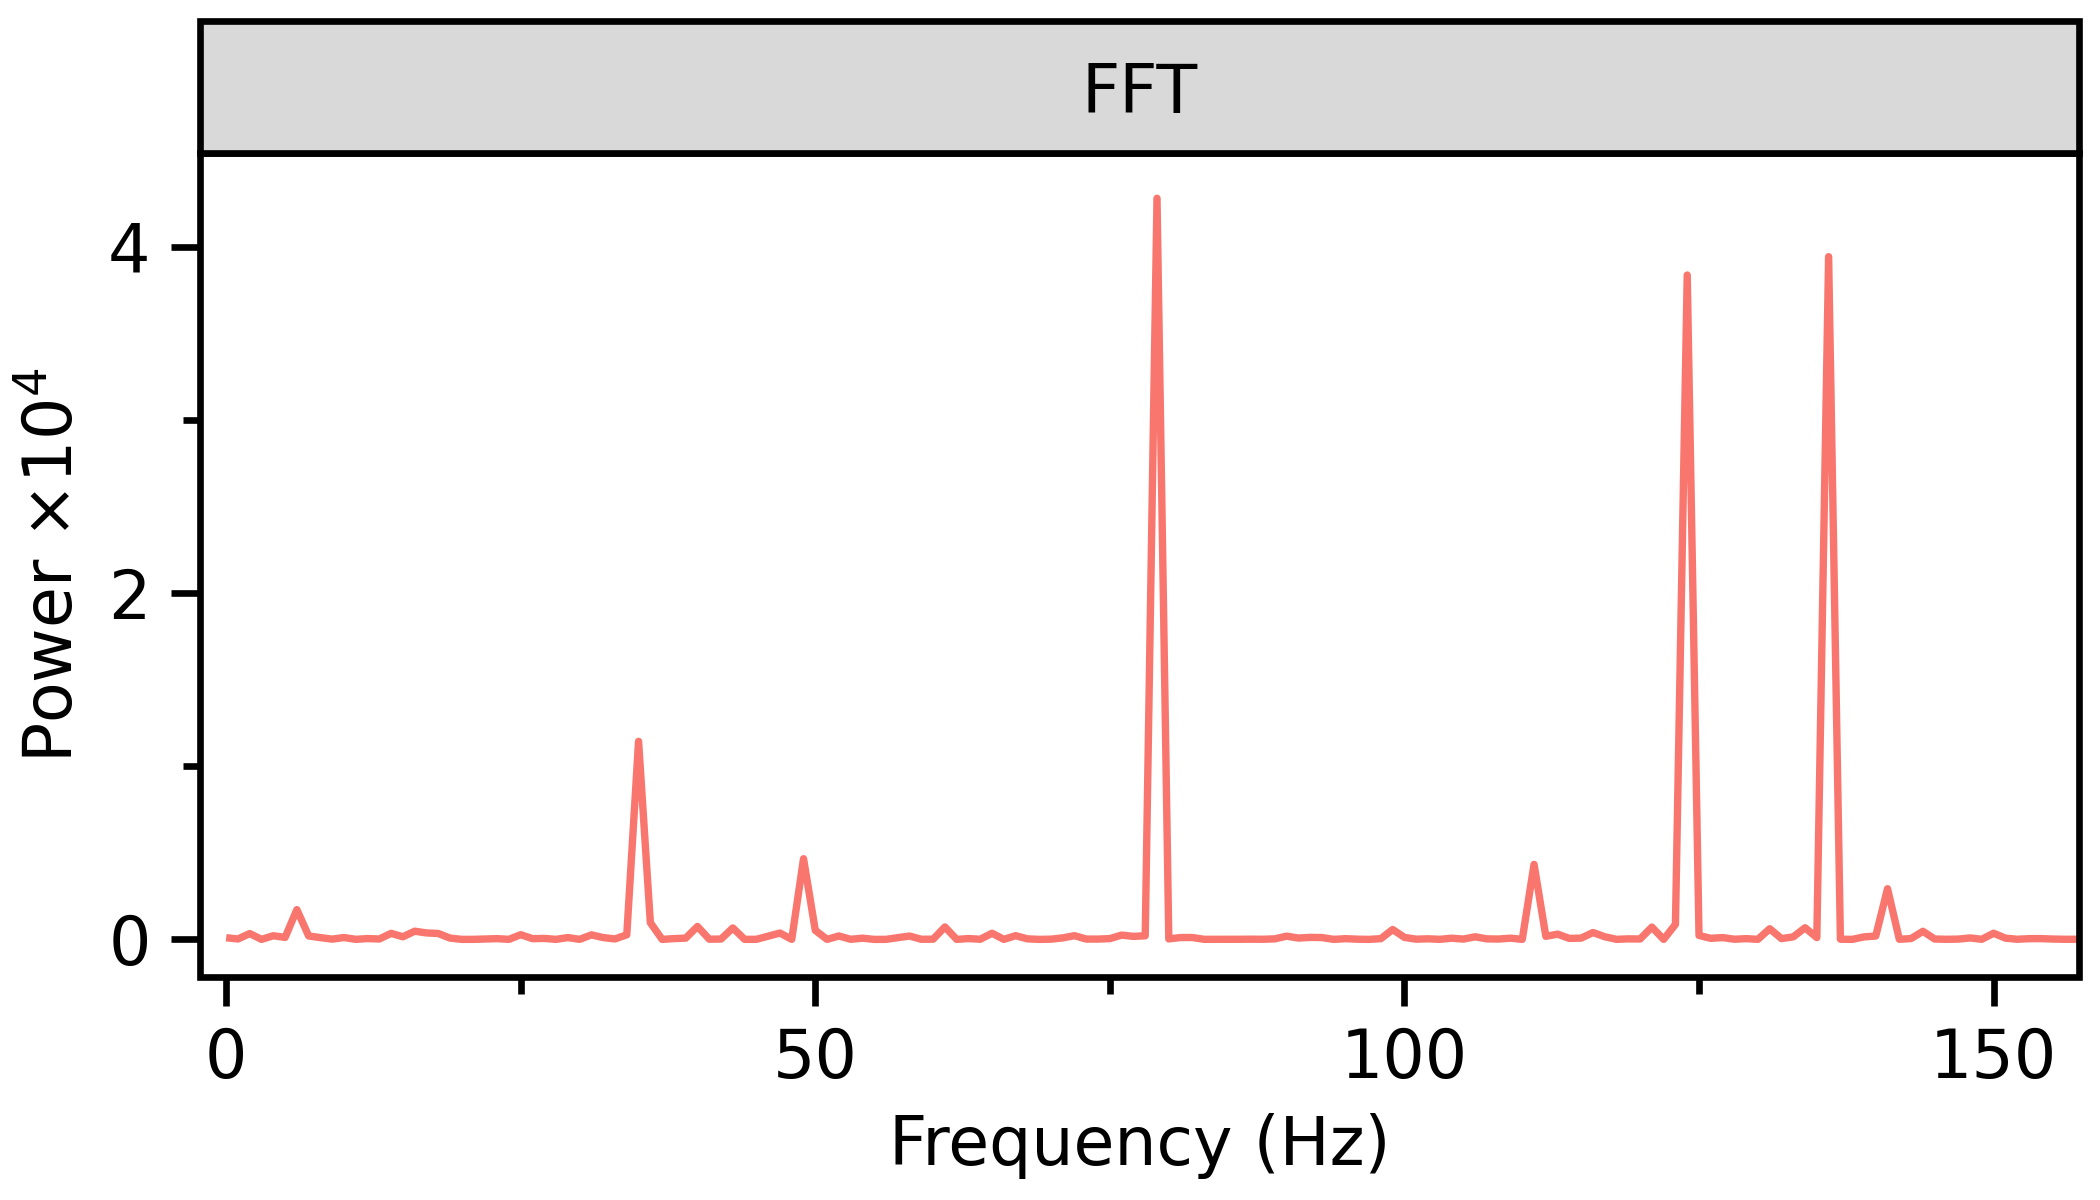

/root/venv/lib/python3.12/site-packages/plotnine/ggplot.py:630: PlotnineWarning: Saving 3.5 x 2 in image.
/root/venv/lib/python3.12/site-packages/plotnine/ggplot.py:631: PlotnineWarning: Filename: /workspace/output/figures/omt_signal_fft.png
/root/venv/lib/python3.12/site-packages/plotnine/ggplot.py:630: PlotnineWarning: Saving 3.5 x 2 in image.
/root/venv/lib/python3.12/site-packages/plotnine/ggplot.py:631: PlotnineWarning: Filename: /workspace/output/figures/omt_signal_fft.pdf


In [19]:
_fig_df = fft_df.with_columns([
    pl.lit("FFT").alias("type"),
    ((pl.col("magnitude")**2) / 1e4).alias("power")
])
fft_fig = (
    p9.ggplot(_fig_df, p9.aes(x="frequency", y="power", color="type")) +
    p9.geom_line() +
    p9.facet_wrap("type", ncol=1, scales="free_y") +
    p9.labs(x="Frequency (Hz)", y=r"Power $\times10^4$") +
    p9.scale_y_continuous(breaks=np.linspace(0, 4, 3)) +
    p9.coord_cartesian(xlim=(5, 150)) +
    p9.guides(color=False, alpha=False) +
    p9.theme_matplotlib() +
    p9.theme(figure_size=(3.5, 2), dpi=300, text=p9.element_text(size=8))
)
fft_fig.show()
fft_fig.save("/workspace/output/figures/omt_signal_fft.png")
fft_fig.save("/workspace/output/figures/omt_signal_fft.pdf")


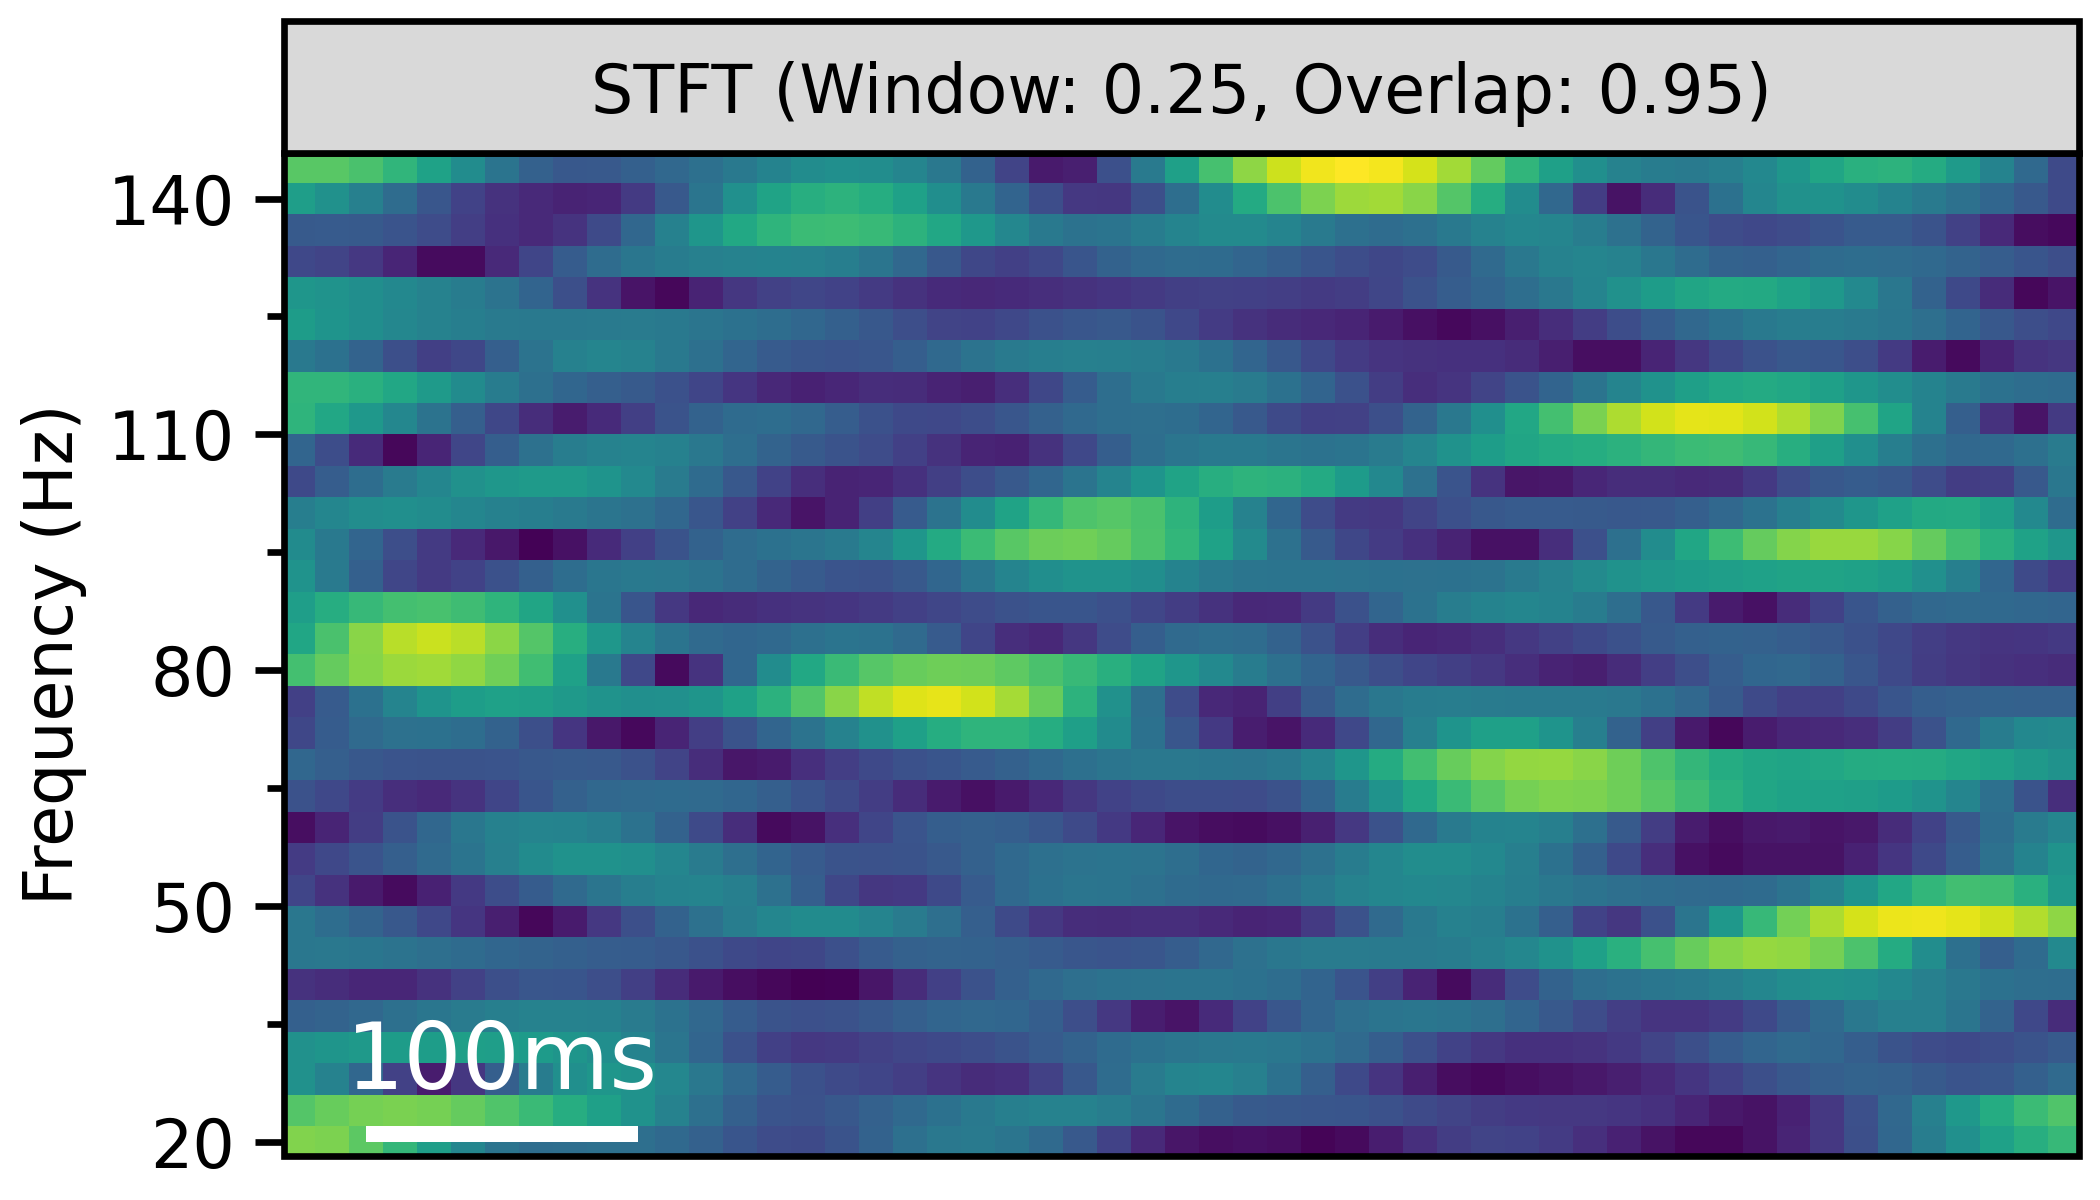

/root/venv/lib/python3.12/site-packages/plotnine/ggplot.py:630: PlotnineWarning: Saving 3.5 x 2 in image.
/root/venv/lib/python3.12/site-packages/plotnine/ggplot.py:631: PlotnineWarning: Filename: /workspace/output/figures/omt_signal_stft.png
/root/venv/lib/python3.12/site-packages/plotnine/ggplot.py:630: PlotnineWarning: Saving 3.5 x 2 in image.
/root/venv/lib/python3.12/site-packages/plotnine/ggplot.py:631: PlotnineWarning: Filename: /workspace/output/figures/omt_signal_stft.pdf


In [13]:
# plot the stft of the signal
from scipy.signal import stft
nperseg = fs/4
overlap= 0.95
# Calculate STFT
f, t_stft, Zxx = stft(omt_signal.flatten(), fs=fs, nperseg=nperseg, noverlap=int(nperseg*overlap), boundary=None)
stft_df = pl.DataFrame({
    "frequency": np.tile(f, len(t_stft)),
    "time": np.repeat(t_stft, len(f)),
    "magnitude": np.abs(Zxx.T.flatten()),
    "type": f"STFT (Window: {nperseg/fs:.2f}, Overlap: {overlap:.2f})"
}).filter(
    pl.col("frequency").is_between(20, 150)
)
stft_fig = (
    p9.ggplot(stft_df, p9.aes(x="time", y="frequency", fill="magnitude")) +
    p9.geom_tile() +
    p9.facet_wrap("~type", scales="free_y") +
    p9.annotate("rect", xmin=0.2, xmax=0.3, ymin=20, ymax=22, fill="white") +
    p9.annotate("text", x=0.25, y=30, label="100ms", ha="center", color="white") +
    p9.scale_y_continuous(breaks=np.arange(20, 151, 30)) +
    p9.labs(x=False, y="Frequency (Hz)", fill="Magnitude") +
    p9.coord_cartesian(xlim=(0.2, 0.8), ylim=(24, 140)) +
    p9.guides(fill=False) +
    p9.theme_matplotlib() +
    p9.theme(figure_size=(3.5, 2), dpi=300, text=p9.element_text(size=8), axis_ticks_x=p9.element_blank(), axis_text_x=p9.element_blank())
)
stft_fig.show()
stft_fig.save("/workspace/output/figures/omt_signal_stft.png")
stft_fig.save("/workspace/output/figures/omt_signal_stft.pdf")


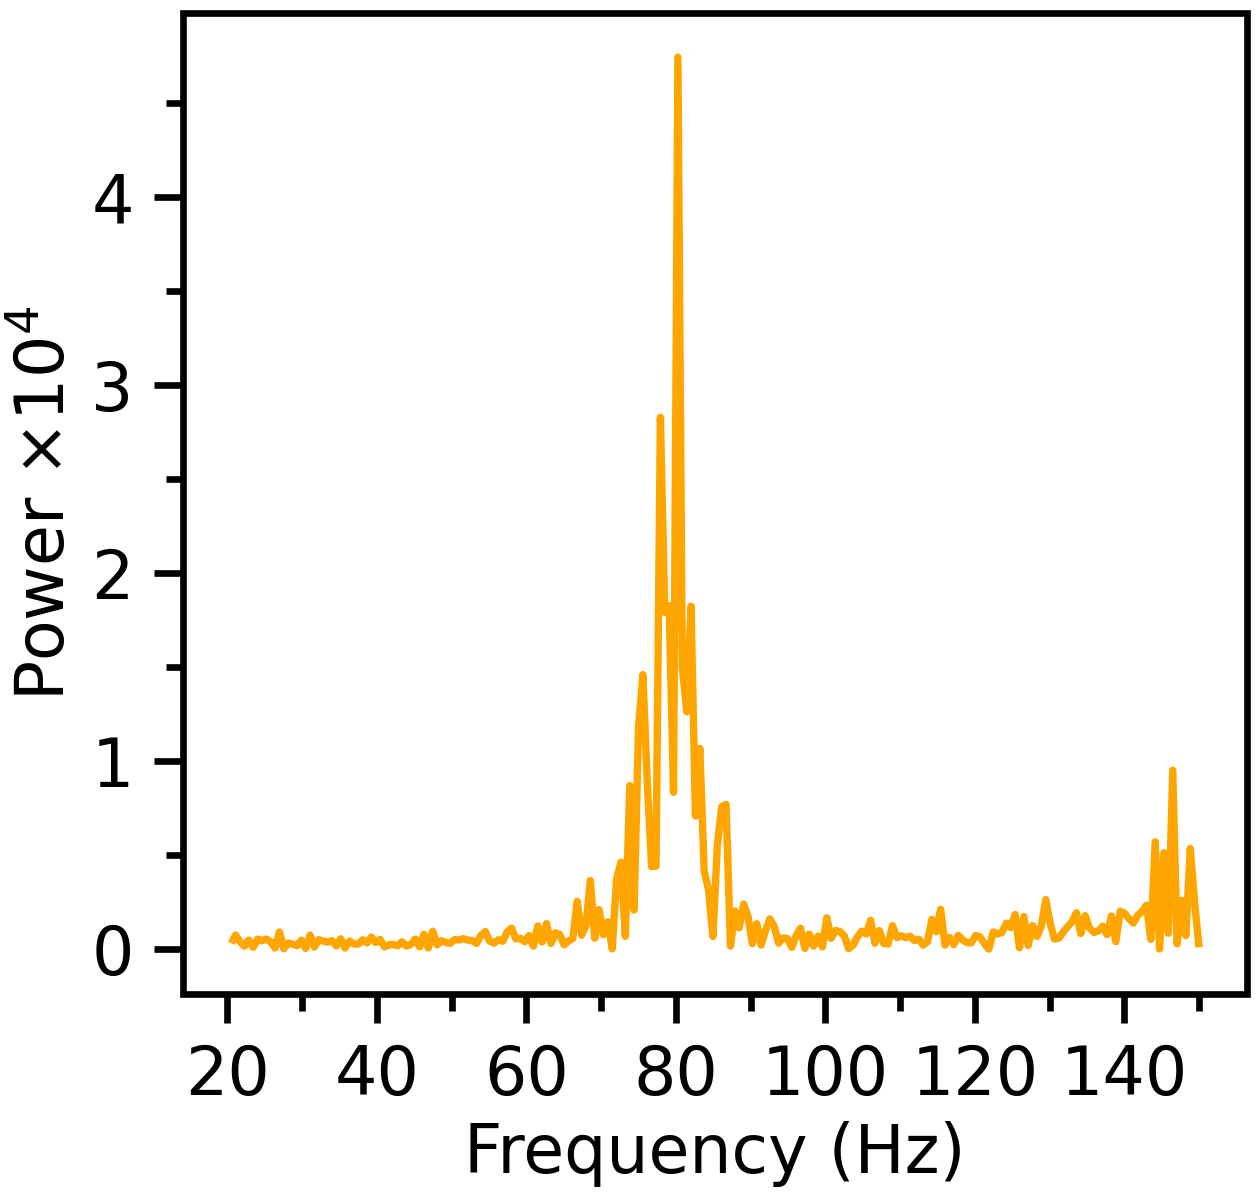

/root/venv/lib/python3.12/site-packages/plotnine/ggplot.py:630: PlotnineWarning: Saving 2.1 x 2 in image.
/root/venv/lib/python3.12/site-packages/plotnine/ggplot.py:631: PlotnineWarning: Filename: /workspace/output/figures/omt_signal_power_spectrum.png
/root/venv/lib/python3.12/site-packages/plotnine/ggplot.py:630: PlotnineWarning: Saving 2.1 x 2 in image.
/root/venv/lib/python3.12/site-packages/plotnine/ggplot.py:631: PlotnineWarning: Filename: /workspace/output/figures/omt_signal_power_spectrum.pdf


In [38]:

# --- Generate OMT Signal ---
omt_signal = np.zeros_like(t)
for _ in range(N):
    rate = np.random.normal(central_frequency, 2)  # Hz
    spike_train = generate_spike_train(rate, duration, jitter=0.001, fs=fs)
    response = convolve_spikes_with_twitch(spike_train, fs=fs, tau=tau)
    omt_signal += response

n_fft = 2**int(np.ceil(np.log2(len(omt_signal))))
omt_signal = np.pad(omt_signal, (0, n_fft - len(omt_signal)))
omt_signal -= omt_signal.mean()

# --- Step 4: Deconvolution (Tikhonov Regularisation) ---
t_kernel = np.arange(0, 0.05, 1/fs)
kernel = normalised_twitch_kernel(t_kernel, tau)
# kernel /= np.sum(kernel) * (1/fs)
omt_signal = omt_signal.flatten()
kernel_padded = np.zeros_like(omt_signal)
kernel_padded[:len(kernel)] = kernel
Y = fft(omt_signal)
H = fft(kernel_padded)
H_conj = np.conj(H)
S_hat_tikhonov = (H_conj / (H_conj * H + tikhonov_lambda)) * Y
s_deconv_tikhonov = np.real(np.fft.ifft(S_hat_tikhonov))
s_deconv_tikhonov -= s_deconv_tikhonov.mean()

# --- Step 5: Power Spectrum ---
N_samples = len(omt_signal)
freqs = fftfreq(N_samples, d=1/fs)[:N_samples//2]
S_deconv_fft = np.abs(fft(s_deconv_tikhonov))[:N_samples//2]
power_spectrum = S_deconv_fft**2

# Limit the frequency range between 20 Hz and 150 Hz
freq_min = 20
freq_max = 150
mask = (freqs >= freq_min) & (freqs <= freq_max)
freqs_limited = freqs[mask]
power_spectrum_limited = power_spectrum[mask]

pl_df = pl.DataFrame({
    "frequency": freqs_limited,
    "power": power_spectrum_limited / 1e4
})

# --- Step 6: Plotting the Power Spectrum ---
fig = (
    p9.ggplot(pl_df, p9.aes(x="frequency", y="power")) +
    p9.geom_line(color='orange') +
    p9.labs(x="Frequency (Hz)", y=r"Power $\times 10^4$") +
    # p9.scale_y_continuous(breaks=np.linspace(0, 4, 4)) +
    p9.scale_x_continuous(breaks=np.arange(0, freq_max, 20)) +
    p9.theme_matplotlib() +
    p9.theme(figure_size=(2.1, 2), dpi=300, text=p9.element_text(size=8))
)

fig.show()
fig.save("/workspace/output/figures/omt_signal_power_spectrum.png")
fig.save("/workspace/output/figures/omt_signal_power_spectrum.pdf")


In [39]:
# Find frequency with maximum power (peak)
# Define the frequency band
band_min = 20
band_max = 150

# Mask for frequencies in the desired band
band_mask = (freqs >= band_min) & (freqs <= band_max)

# Apply mask to power spectrum
band_freqs = freqs[band_mask]
band_power = power_spectrum[band_mask]

# Find peak in this band
band_peak_index = np.argmax(band_power)
band_peak_freq = band_freqs[band_peak_index]
band_peak_power = band_power[band_peak_index]

print(f"Band Peak Frequency: {band_peak_freq.item():.1f}Hz, Band Peak Power: {band_peak_power.item()}, Error: {np.abs(band_peak_freq - central_frequency):.1f}Hz")

Band Peak Frequency: 80.3Hz, Band Peak Power: 47436.08373864523, Error: 0.3Hz


In [40]:
# Parameters
frequencies = np.arange(20, 150, 1)
n_trials = 100

def simulate_and_estimate_peak(rate):
    peak_freqs = []
    for _ in range(n_trials):
        omt_signal = np.zeros_like(t)
        t_kernel = np.arange(0, 0.05, 1/fs)
        kernel = normalised_twitch_kernel(t_kernel, tau)
        for _ in range(N):
            isi = np.random.normal(1/rate, 0.001, size=int(rate * duration * 2))
            spike_times = np.cumsum(isi)
            spike_times = spike_times[spike_times < duration]
            spike_train = np.zeros_like(t)
            spike_idx = (spike_times * fs).astype(int)
            spike_train[spike_idx] = 1

            response = convolve(spike_train, kernel, mode="same")
            omt_signal += response

        # Zero-padding for FFT
        n_fft = 2**int(np.ceil(np.log2(len(omt_signal))))
        omt_signal = np.pad(omt_signal, (0, n_fft - len(omt_signal)))
        kernel_padded = np.zeros_like(omt_signal)
        kernel_padded[:len(kernel)] = kernel

        Y = fft(omt_signal)
        H = fft(kernel_padded)
        lambda_reg = 1e-5
        H_conj = np.conj(H)
        S_hat_tikhonov = (H_conj / (H_conj * H + lambda_reg)) * Y
        s_deconv = np.real(np.fft.ifft(S_hat_tikhonov))
        s_deconv -= s_deconv.mean()

        N_samples = len(omt_signal)
        freqs_fft = fftfreq(N_samples, d=1/fs)[:N_samples//2]
        S_fft = np.abs(fft(s_deconv))[:N_samples//2]
        power_spectrum = S_fft**2
        band_mask = (freqs_fft >= 20) & (freqs_fft <= 150)
        peak_idx = np.argmax(power_spectrum[band_mask])
        peak_freq = freqs_fft[band_mask][peak_idx]
        peak_freqs.append(peak_freq)

    return np.array(peak_freqs)

# Re-run the sweep with updated function
errors = []
for i, f in enumerate(tqdm(frequencies, desc="Sweeping base frequencies (padded)")):
    detected = simulate_and_estimate_peak(f)
    for peak in detected:
        errors.append((i, f, peak))

# Convert to DataFrame and plot
error_df = pl.DataFrame(errors, schema=["sample", "sim_freq", "obs_freq"], orient="row")
error_df


Sweeping base frequencies (padded):   0%|          | 0/130 [00:00<?, ?it/s]

shape: (13_000, 3)
┌────────┬──────────┬────────────┐
│ sample ┆ sim_freq ┆ obs_freq   │
│ ---    ┆ ---      ┆ ---        │
│ i64    ┆ i64      ┆ f64        │
╞════════╪══════════╪════════════╡
│ 0      ┆ 20       ┆ 39.84375   │
│ 0      ┆ 20       ┆ 39.84375   │
│ 0      ┆ 20       ┆ 39.84375   │
│ 0      ┆ 20       ┆ 39.84375   │
│ 0      ┆ 20       ┆ 39.84375   │
│ …      ┆ …        ┆ …          │
│ 129    ┆ 149      ┆ 142.96875  │
│ 129    ┆ 149      ┆ 145.898438 │
│ 129    ┆ 149      ┆ 148.242188 │
│ 129    ┆ 149      ┆ 150.0      │
│ 129    ┆ 149      ┆ 144.140625 │
└────────┴──────────┴────────────┘

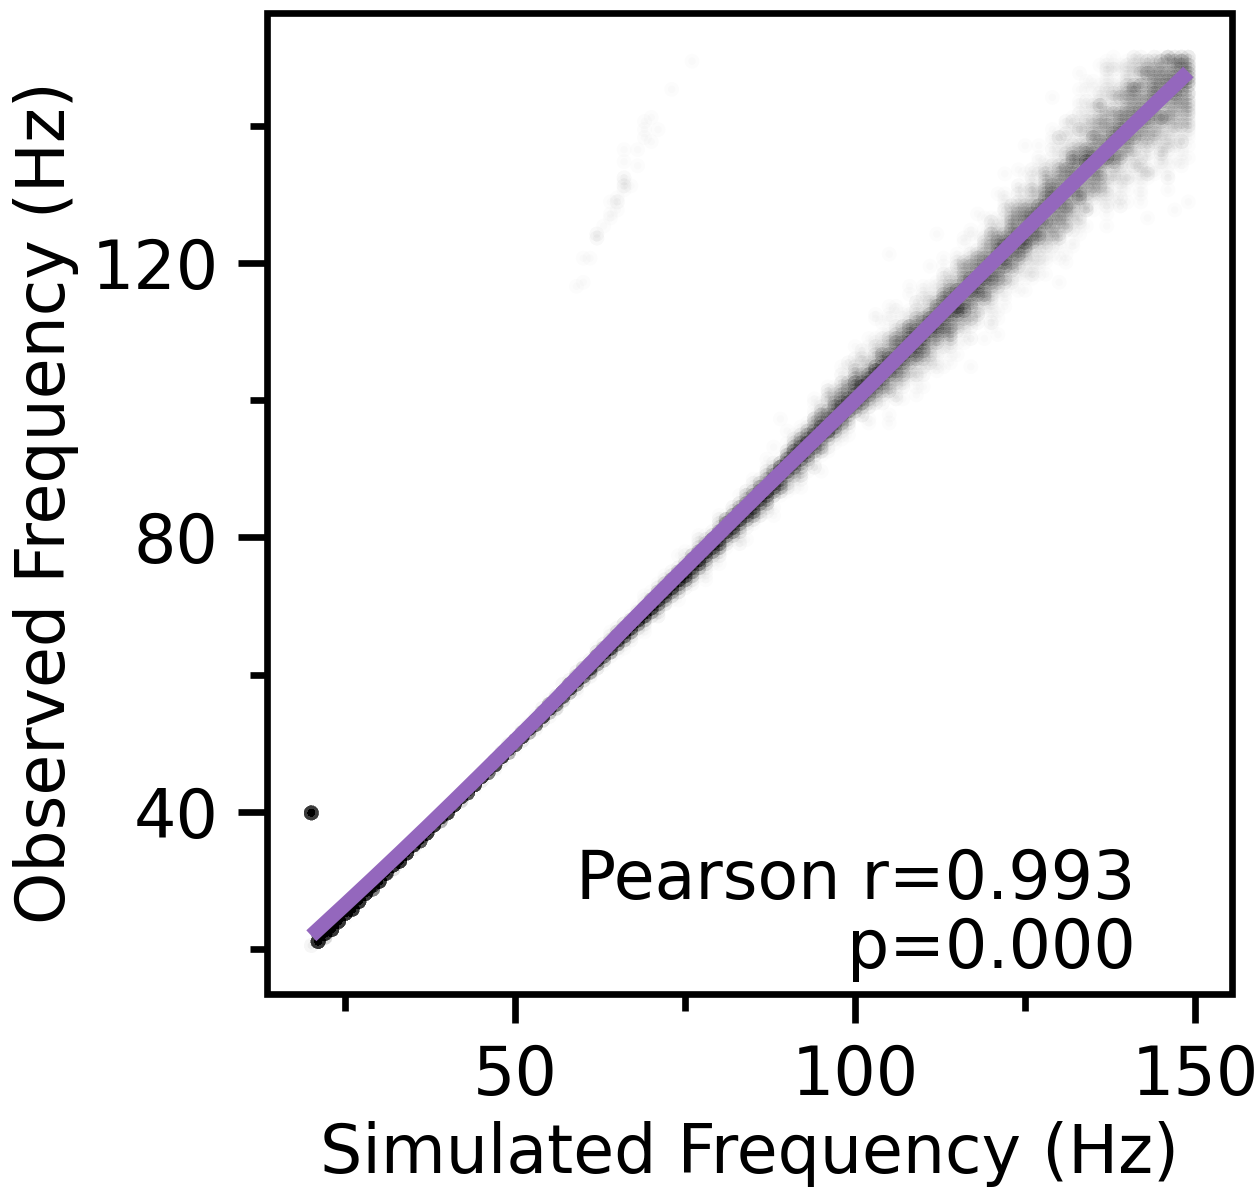

/root/venv/lib/python3.12/site-packages/plotnine/ggplot.py:630: PlotnineWarning: Saving 2.1 x 2 in image.
/root/venv/lib/python3.12/site-packages/plotnine/ggplot.py:631: PlotnineWarning: Filename: /workspace/output/figures/omt_signal_frequency_sweep.png
/root/venv/lib/python3.12/site-packages/plotnine/ggplot.py:630: PlotnineWarning: Saving 2.1 x 2 in image.
/root/venv/lib/python3.12/site-packages/plotnine/ggplot.py:631: PlotnineWarning: Filename: /workspace/output/figures/omt_signal_frequency_sweep.pdf


In [41]:
from scipy.stats import pearsonr

pearsonr, pvalue = pearsonr(error_df["sim_freq"], error_df["obs_freq"])

fig = (
    p9.ggplot(error_df, p9.aes(x="sim_freq", y="obs_freq")) +
    p9.geom_point(size=0.01, alpha=0.01) +
    p9.geom_smooth(method="loess", color="#9467bd", alpha=1.0) +
    p9.annotate("text", x=100, y=30, label=f"Pearson r={pearsonr:.3f}", size=8, color="#000000") +
    p9.annotate("text", x=120, y=20, label=f"p={pvalue:.3f}", size=8, color="#000000") +
    p9.labs(x="Simulated Frequency (Hz)", y="Observed Frequency (Hz)") +
    p9.theme_matplotlib() +
    p9.theme(figure_size=(2.1, 2), dpi=300, text=p9.element_text(size=8))
)
fig.show()
fig.save("/workspace/output/figures/omt_signal_frequency_sweep.png")
fig.save("/workspace/output/figures/omt_signal_frequency_sweep.pdf")

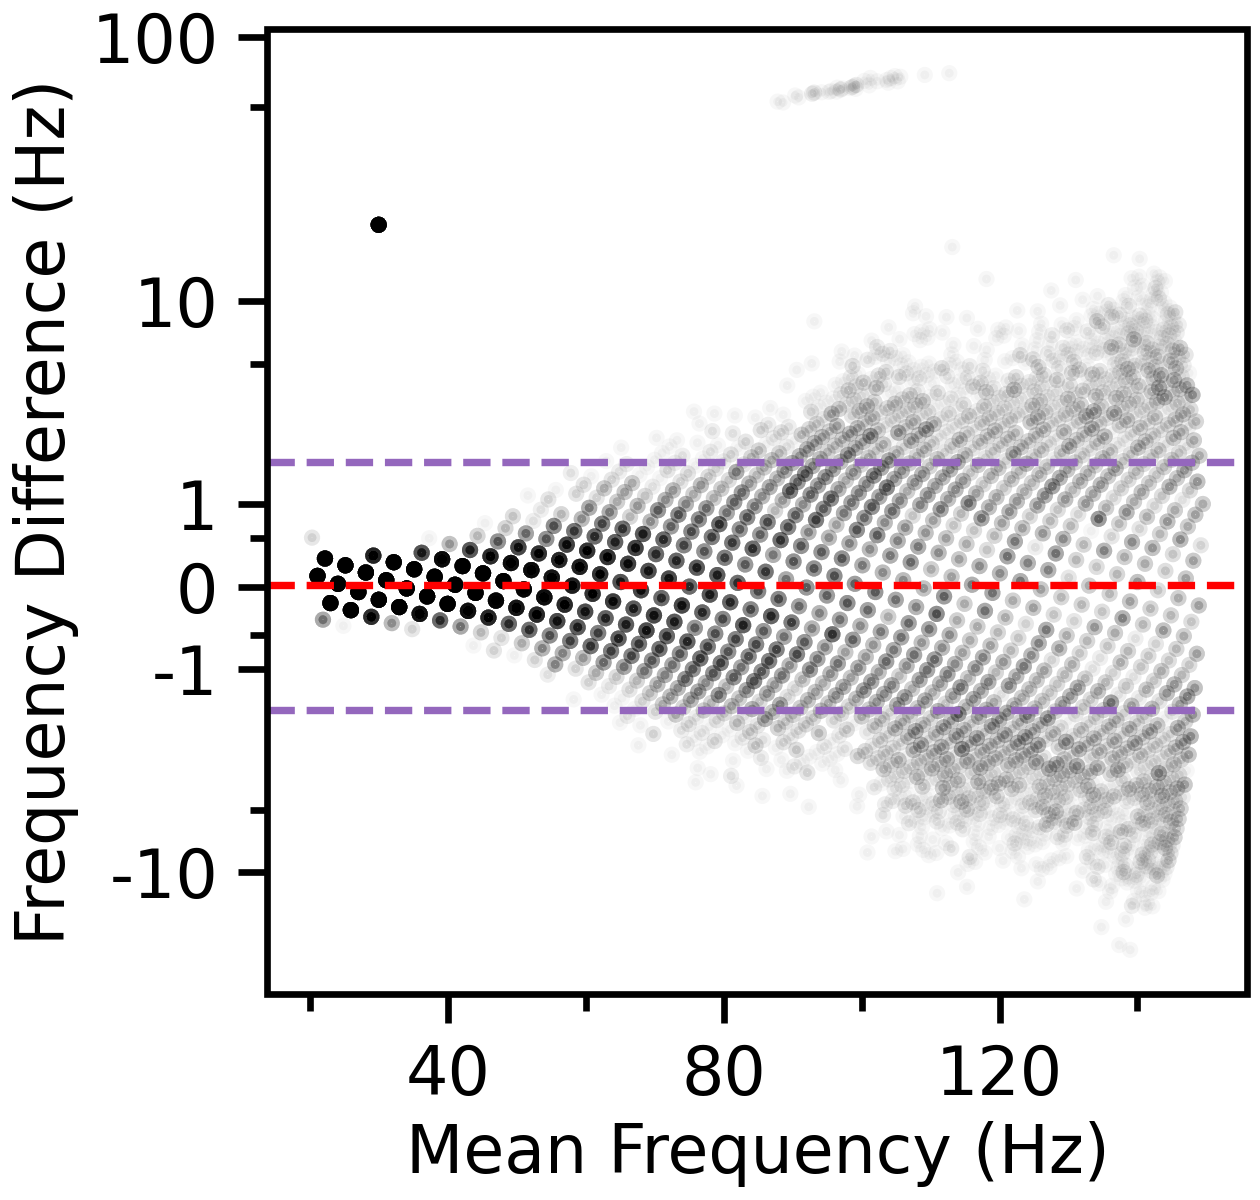

/root/venv/lib/python3.12/site-packages/plotnine/ggplot.py:630: PlotnineWarning: Saving 2.1 x 2 in image.
/root/venv/lib/python3.12/site-packages/plotnine/ggplot.py:631: PlotnineWarning: Filename: /workspace/output/figures/omt_signal_bland_altman_iqr.png
/root/venv/lib/python3.12/site-packages/plotnine/ggplot.py:630: PlotnineWarning: Saving 2.1 x 2 in image.
/root/venv/lib/python3.12/site-packages/plotnine/ggplot.py:631: PlotnineWarning: Filename: /workspace/output/figures/omt_signal_bland_altman_iqr.pdf


In [42]:
# Add Bland-Altman columns
pl_df = error_df.with_columns([
    ((pl.col("sim_freq") + pl.col("obs_freq")) / 2).alias("mean_frequency"),
    (pl.col("obs_freq") - pl.col("sim_freq")).alias("diff_frequency")
])

# Compute mean and limits of agreement
diff_freq = pl_df["diff_frequency"].to_numpy()
# Compute median and IQR for difference
diff_median = np.median(diff_freq)
iqr = np.percentile(diff_freq, 75) - np.percentile(diff_freq, 25)
iqr_upper = diff_median + 1.5 * iqr
iqr_lower = diff_median - 1.5 * iqr

# Update plot with median and IQR-based limits
bland_altman_plot_iqr = (
    p9.ggplot(pl_df, p9.aes(x="mean_frequency", y="diff_frequency")) +
    p9.geom_point(alpha=0.03, size=0.1) +
    p9.geom_hline(yintercept=diff_median, linetype='dashed', color='red') +
    p9.geom_hline(yintercept=iqr_upper, linetype='dashed', color="#9467bd") +
    p9.geom_hline(yintercept=iqr_lower, linetype='dashed', color="#9467bd") +
    p9.scale_y_symlog(breaks=[-10, int(iqr_lower), 0, int(iqr_upper), 10, 100]) +
    p9.labs(
        x="Mean Frequency (Hz)",
        y="Frequency Difference (Hz)"
    ) +
    p9.theme_matplotlib() +
    p9.theme(figure_size=(2.1, 2), dpi=300, text=p9.element_text(size=8))
)

bland_altman_plot_iqr.show()
bland_altman_plot_iqr.save("/workspace/output/figures/omt_signal_bland_altman_iqr.png")
bland_altman_plot_iqr.save("/workspace/output/figures/omt_signal_bland_altman_iqr.pdf")

In [134]:
frequencies = np.arange(20, 150, 1)
n_trials = 10

def simulate_and_estimate_power_capture(rate, freq_band=5):
    power_capture = []
    t_kernel = np.arange(0, 0.05, 1/fs)
    kernel = normalised_twitch_kernel(t_kernel, tau)
    for _ in range(n_trials):
        omt_signal = np.zeros_like(t)
        for _ in range(N):
            isi = np.random.normal(1/rate, 0.001, size=int(rate * duration * 2))
            spike_times = np.cumsum(isi)
            spike_times = spike_times[spike_times < duration]
            spike_train = np.zeros_like(t)
            spike_idx = (spike_times * fs).astype(int)
            spike_train[spike_idx] = 1

            response = convolve(spike_train, kernel, mode="same")
            omt_signal += response

        kernel /= np.sum(kernel) * (1/fs)

        # Zero-padding for FFT
        n_fft = 2**int(np.ceil(np.log2(len(omt_signal))))
        omt_signal = np.pad(omt_signal, (0, n_fft - len(omt_signal)))
        kernel_padded = np.zeros_like(omt_signal)
        kernel_padded[:len(kernel)] = kernel

        Y = fft(omt_signal)
        H = fft(kernel_padded)
        lambda_reg = 1e-5
        H_conj = np.conj(H)
        S_hat_tikhonov = (H_conj / (H_conj * H + lambda_reg)) * Y
        s_deconv = np.real(np.fft.ifft(S_hat_tikhonov))
        s_deconv -= s_deconv.mean()

        N_samples = len(omt_signal)
        freqs_fft = fftfreq(N_samples, d=1/fs)[:N_samples//2]
        S_fft = np.abs(fft(s_deconv))[:N_samples//2]
        power_spectrum = S_fft**2

        # Restrict to physiological band
        band_limit_mask = (freqs_fft >= 20) & (freqs_fft <= 150)
        band_power_total = np.sum(power_spectrum[band_limit_mask])

        # Now mask around target frequency (±freq_band Hz)
        target_band_mask = (freqs_fft >= rate - freq_band) & (freqs_fft <= rate + freq_band) & band_limit_mask
        band_power_target = np.sum(power_spectrum[target_band_mask])

        power_capture_normalised = band_power_target / band_power_total if band_power_total > 0 else 0.0
        power_capture.append(power_capture_normalised)

    return np.array(power_capture)

# Re-run the sweep with updated function
lambda_sens = []
required_bands = np.arange(1, 20, 1)
for i, f in enumerate(tqdm(frequencies, desc="Sweeping base frequencies (padded)")):
    for band in required_bands:
        captured_power = simulate_and_estimate_power_capture(f, freq_band=band)
        for power in captured_power:
            lambda_sens.append((i, band, f, power))

Sweeping base frequencies (padded):   0%|          | 0/130 [00:00<?, ?it/s]

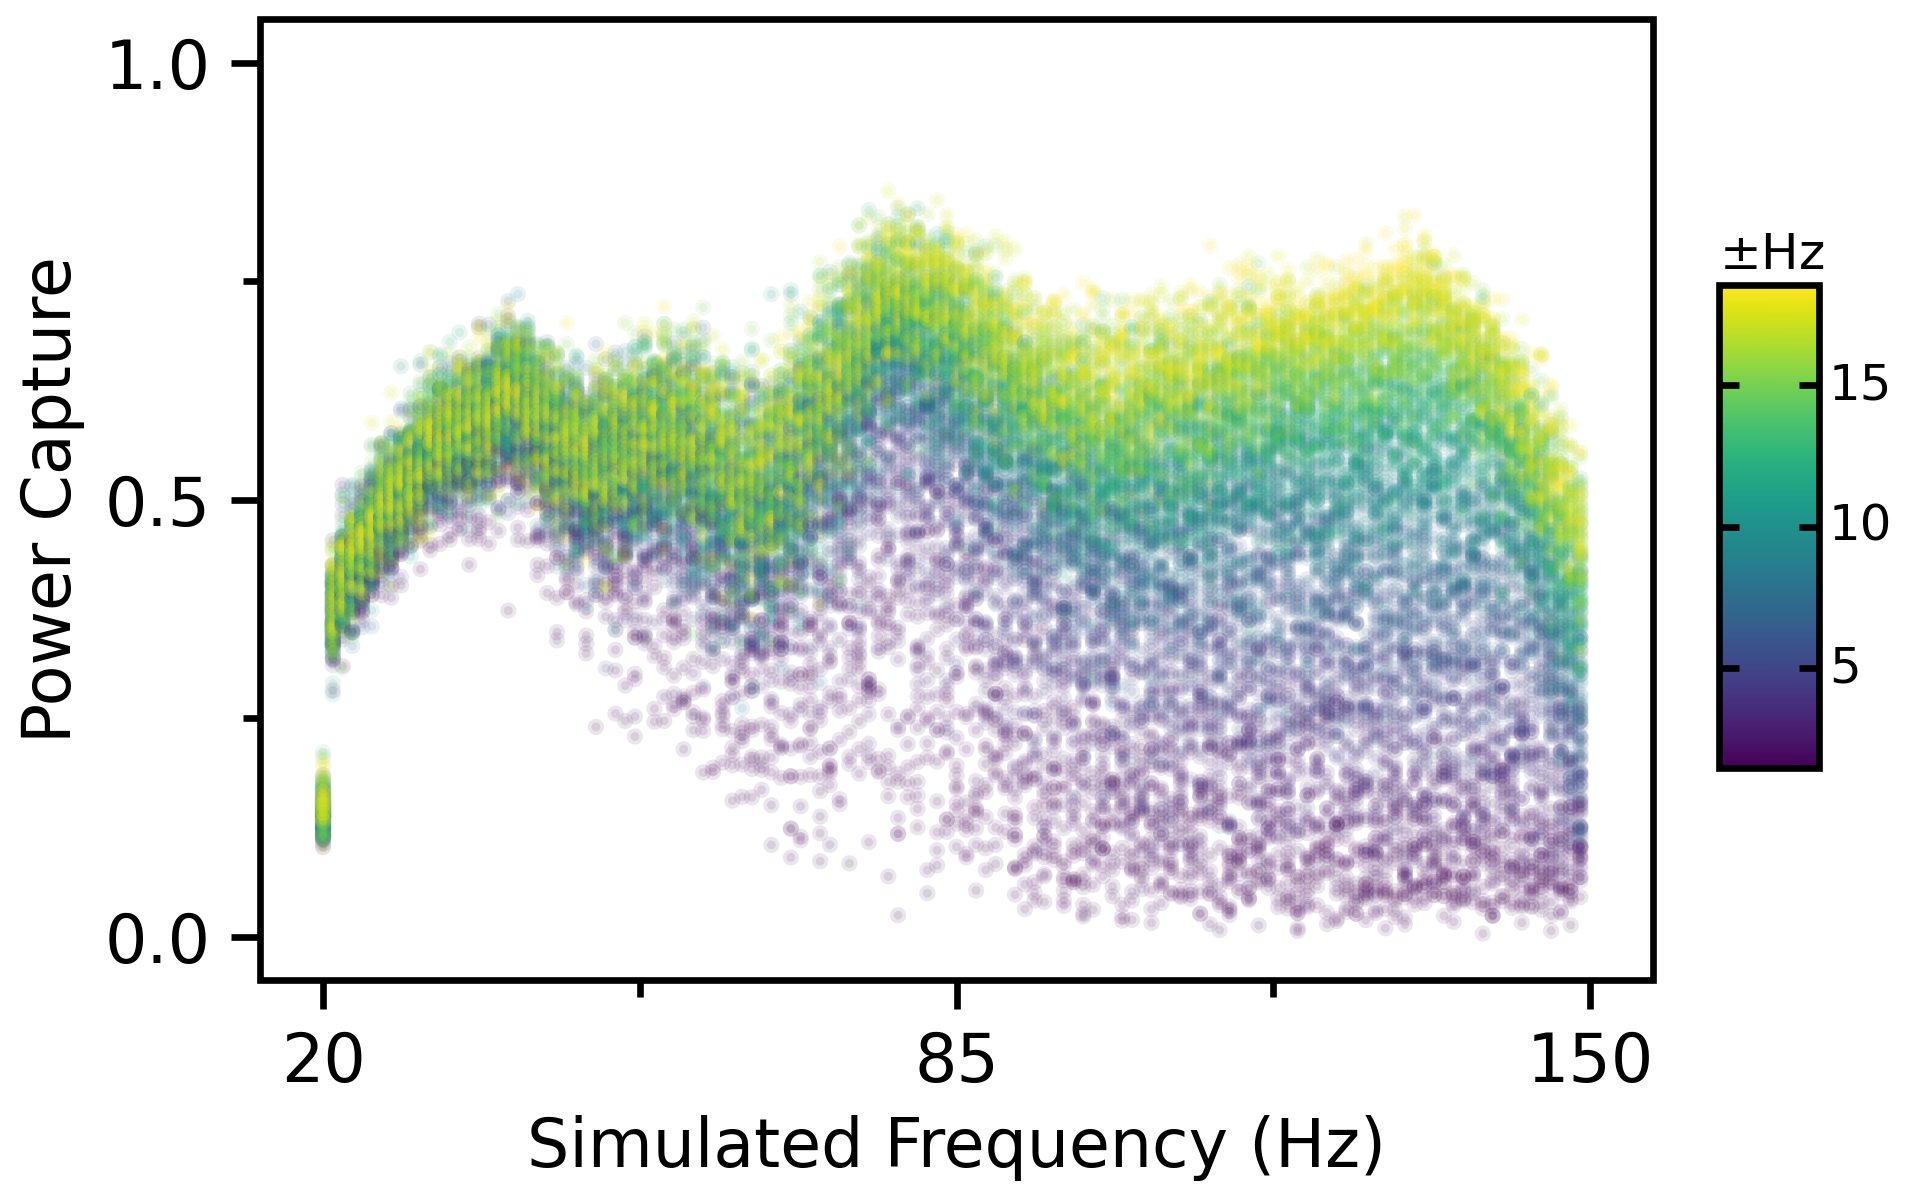

/root/venv/lib/python3.12/site-packages/plotnine/ggplot.py:630: PlotnineWarning: Saving 3.2 x 2 in image.
/root/venv/lib/python3.12/site-packages/plotnine/ggplot.py:631: PlotnineWarning: Filename: /workspace/output/figures/omt_signal_power_capture.png
/root/venv/lib/python3.12/site-packages/plotnine/ggplot.py:630: PlotnineWarning: Saving 3.2 x 2 in image.
/root/venv/lib/python3.12/site-packages/plotnine/ggplot.py:631: PlotnineWarning: Filename: /workspace/output/figures/omt_signal_power_capture.pdf


In [135]:
# plot the power capture results with the x-axis being the simulated frequency and the y-axis being the captured power
power_capture_df = pl.DataFrame(
    lambda_sens,
    schema=["sample", "band", "sim_freq", "captured_power"],
    orient="row",
)

fig_power_capture = (
    p9.ggplot(power_capture_df, p9.aes(x="sim_freq", y="captured_power", color="band"))
    + p9.geom_point(size=0.1, alpha=0.1)
    + p9.coord_cartesian(xlim=(20, 150), ylim=(0, 1.0))
    + p9.scale_x_continuous(breaks=np.linspace(20, 150, 3))
    + p9.scale_y_continuous(breaks=np.linspace(0, 1, 3))
    + p9.labs(x="Simulated Frequency (Hz)", y="Power Capture", color=r"$\pm$Hz")
    + p9.theme_matplotlib()
    + p9.theme(
        figure_size=(3.2, 2),
        dpi=300,
        text=p9.element_text(size=8),
        legend_position="right",
        legend_text=p9.element_text(size=6),
        legend_title=p9.element_text(size=6),
        legend_key_size=8,
        legend_spacing=4,
    )
)
fig_power_capture.show()
fig_power_capture.save("/workspace/output/figures/omt_signal_power_capture.png")
fig_power_capture.save("/workspace/output/figures/omt_signal_power_capture.pdf")

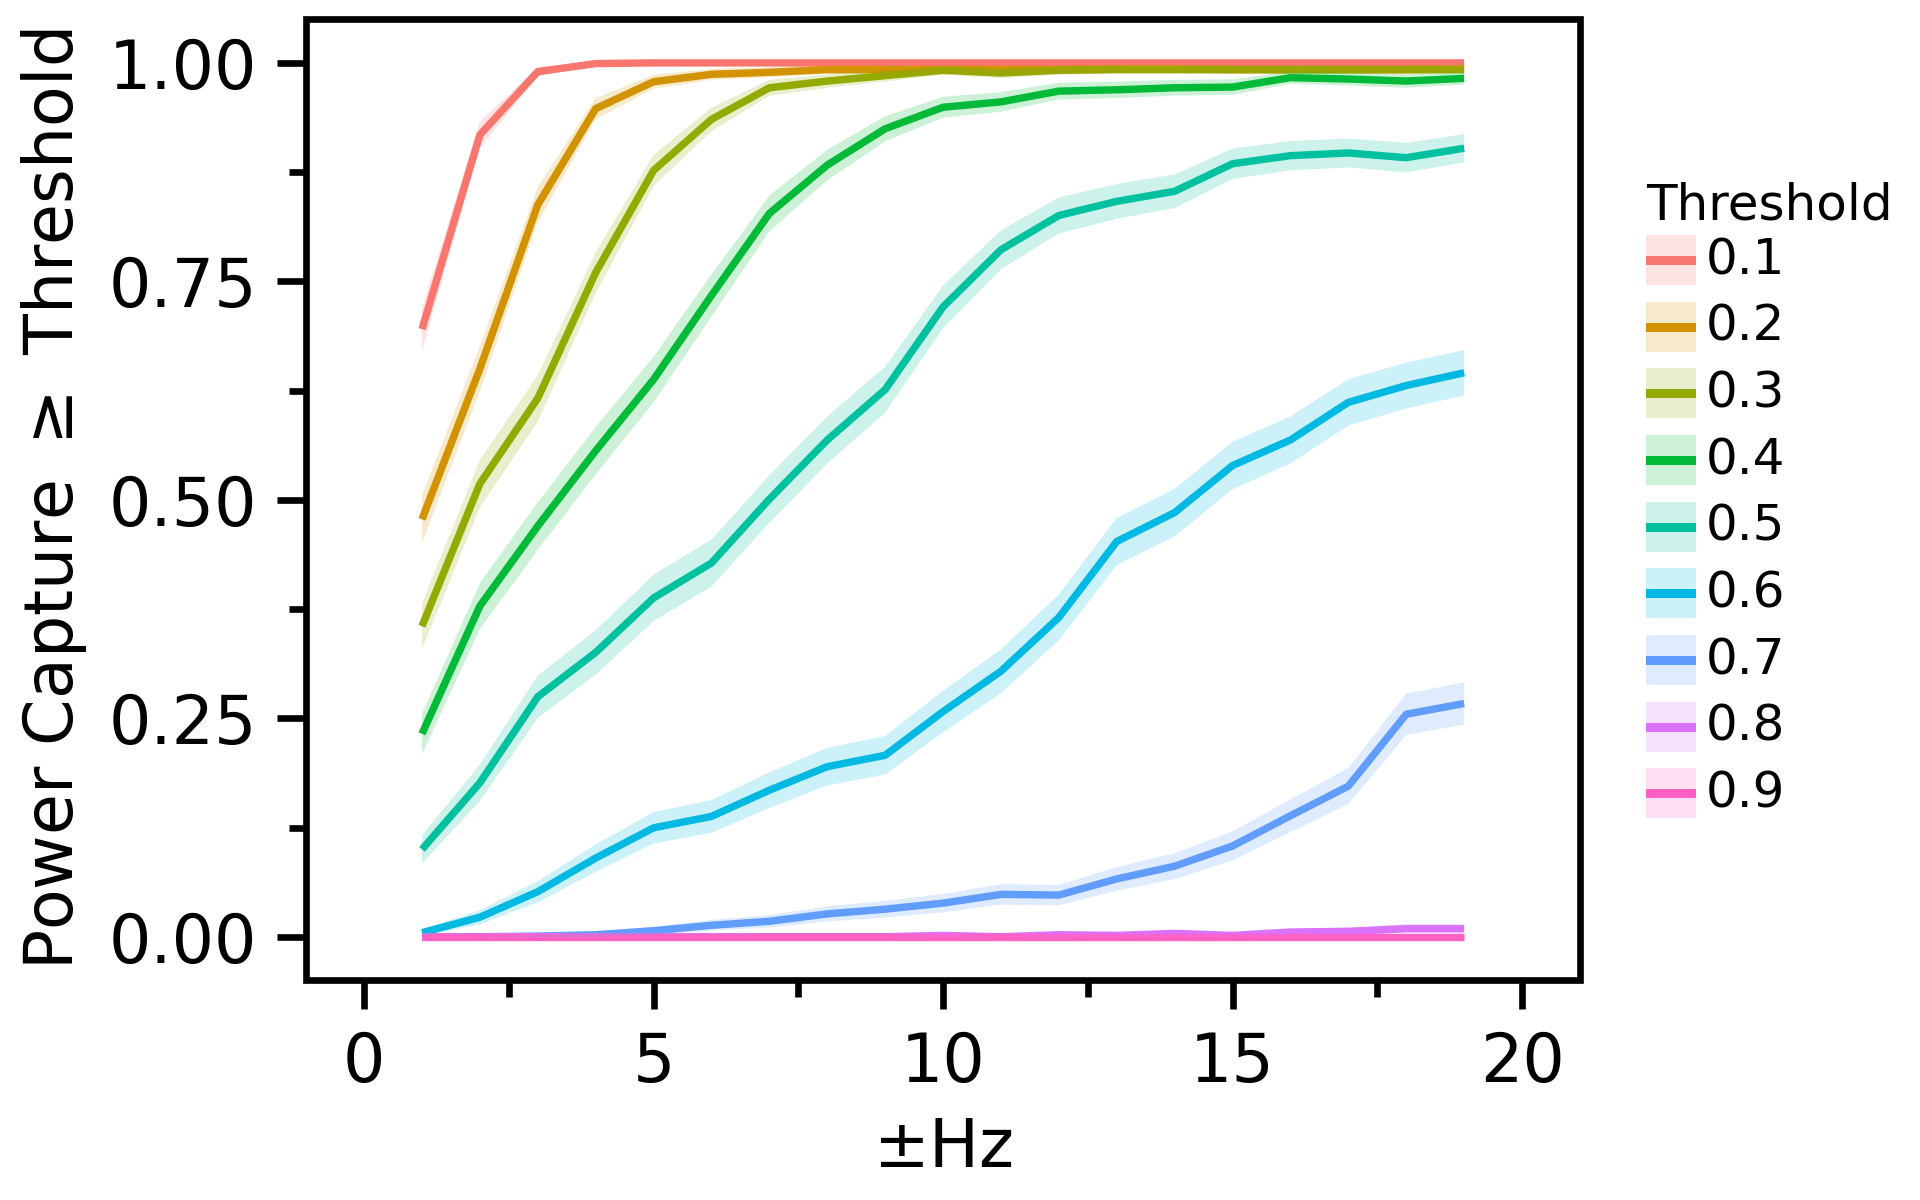

/root/venv/lib/python3.12/site-packages/plotnine/ggplot.py:630: PlotnineWarning: Saving 3.2 x 2 in image.
/root/venv/lib/python3.12/site-packages/plotnine/ggplot.py:631: PlotnineWarning: Filename: /workspace/output/figures/omt_signal_power_capture_frac_thresholds.png
/root/venv/lib/python3.12/site-packages/plotnine/ggplot.py:630: PlotnineWarning: Saving 3.2 x 2 in image.
/root/venv/lib/python3.12/site-packages/plotnine/ggplot.py:631: PlotnineWarning: Filename: /workspace/output/figures/omt_signal_power_capture_frac_thresholds.pdf


In [137]:
thresholds = np.linspace(0.1, 1, 9, endpoint=False)
agg_dfs = []

for thresh in thresholds:
    df = (
        power_capture_df
        .with_columns([
            (pl.col("captured_power") >= thresh).cast(pl.Float64).alias("above_thresh")
        ])
        .group_by("band")
        .agg([
            pl.mean("above_thresh").alias("frac_above"),
            pl.std("above_thresh").alias("std_above"),
            pl.len().alias("n_samples"),
        ])
        .with_columns([
            (pl.lit(thresh).round(2)).alias("threshold"),
            (pl.col("frac_above") + 1.96 * pl.col("std_above") / pl.col("n_samples").cast(pl.Float64).sqrt()).alias("up95"),
            (pl.col("frac_above") - 1.96 * pl.col("std_above") / pl.col("n_samples").cast(pl.Float64).sqrt()).alias("dw95")
        ])
        .select(["band", "threshold", "frac_above", "up95", "dw95", "n_samples"])
        .sort("band")
    )
    agg_dfs.append(df)

power_capture_frac_df = pl.concat(agg_dfs)
fig_power_capture_frac = (
    p9.ggplot(power_capture_frac_df.to_pandas(), p9.aes(x="band", y="frac_above", colour="factor(threshold)"))
    + p9.geom_line()
    + p9.geom_ribbon(
        p9.aes(ymin="dw95", ymax="up95", fill="factor(threshold)"),
        alpha=0.2,
        colour=None
    )
    + p9.labs(
        x=r"$\pm$Hz",
        y=r"Power Capture $\geq$ Threshold",
        colour="Threshold",
        fill="Threshold"
    )
    + p9.scale_x_continuous(breaks=np.arange(0, 21, 5))
    + p9.scale_y_continuous(breaks=np.linspace(0, 1, 5))
    + p9.coord_cartesian(ylim=(0, 1), xlim=(0, 20))
    + p9.theme_matplotlib()
    + p9.theme(
        figure_size=(3.2, 2),
        dpi=300,
        text=p9.element_text(size=8),
        legend_text=p9.element_text(size=6),
        legend_title=p9.element_text(size=6),
        legend_key_size=6
    )
)
fig_power_capture_frac.show()
fig_power_capture_frac.save("/workspace/output/figures/omt_signal_power_capture_frac_thresholds.png")
fig_power_capture_frac.save("/workspace/output/figures/omt_signal_power_capture_frac_thresholds.pdf")


In [138]:
frequencies = np.arange(20, 150, 1)
n_trials = 10

def simulate_and_estimate_power_capture(rate, freq_band=5, lambda_reg=1e-5):
    power_capture = []
    for _ in range(n_trials):
        omt_signal = np.zeros_like(t)
        for _ in range(N):
            isi = np.random.normal(1/rate, 0.001, size=int(rate * duration * 2))
            spike_times = np.cumsum(isi)
            spike_times = spike_times[spike_times < duration]
            spike_train = np.zeros_like(t)
            spike_idx = (spike_times * fs).astype(int)
            spike_train[spike_idx] = 1

            t_kernel = np.arange(0, 0.05, 1/fs)
            kernel = twitch_kernel(t_kernel, tau)
            response = convolve(spike_train, kernel, mode="same")
            omt_signal += response

        kernel /= np.sum(kernel) * (1/fs)

        # Zero-padding for FFT
        n_fft = 2**int(np.ceil(np.log2(len(omt_signal))))
        omt_signal = np.pad(omt_signal, (0, n_fft - len(omt_signal)))
        kernel_padded = np.zeros_like(omt_signal)
        kernel_padded[:len(kernel)] = kernel

        Y = fft(omt_signal)
        H = fft(kernel_padded)
        H_conj = np.conj(H)
        S_hat_tikhonov = (H_conj / (H_conj * H + lambda_reg)) * Y
        s_deconv = np.real(np.fft.ifft(S_hat_tikhonov))
        s_deconv -= s_deconv.mean()

        N_samples = len(omt_signal)
        freqs_fft = fftfreq(N_samples, d=1/fs)[:N_samples//2]
        S_fft = np.abs(fft(s_deconv))[:N_samples//2]
        power_spectrum = S_fft**2

        # Restrict to physiological band
        band_limit_mask = (freqs_fft >= 20) & (freqs_fft <= 150)
        band_power_total = np.sum(power_spectrum[band_limit_mask])

        # Now mask around target frequency (±freq_band Hz)
        target_band_mask = (freqs_fft >= rate - freq_band) & (freqs_fft <= rate + freq_band) & band_limit_mask
        band_power_target = np.sum(power_spectrum[target_band_mask])

        power_capture_normalised = band_power_target / band_power_total if band_power_total > 0 else 0.0
        power_capture.append(power_capture_normalised)

    return np.array(power_capture)

# Re-run the sweep with updated function
lambda_sens = []
required_lambda = np.linspace(1e-8, 1e-1, 10)
for i, f in enumerate(tqdm(frequencies, desc="Sweeping base frequencies (padded)")):
    for lambda_reg in required_lambda:
        captured_power = simulate_and_estimate_power_capture(f, freq_band=10, lambda_reg=lambda_reg)
        for power in captured_power:
            lambda_sens.append((i, lambda_reg, f, power))
            


Sweeping base frequencies (padded):   0%|          | 0/130 [00:00<?, ?it/s]

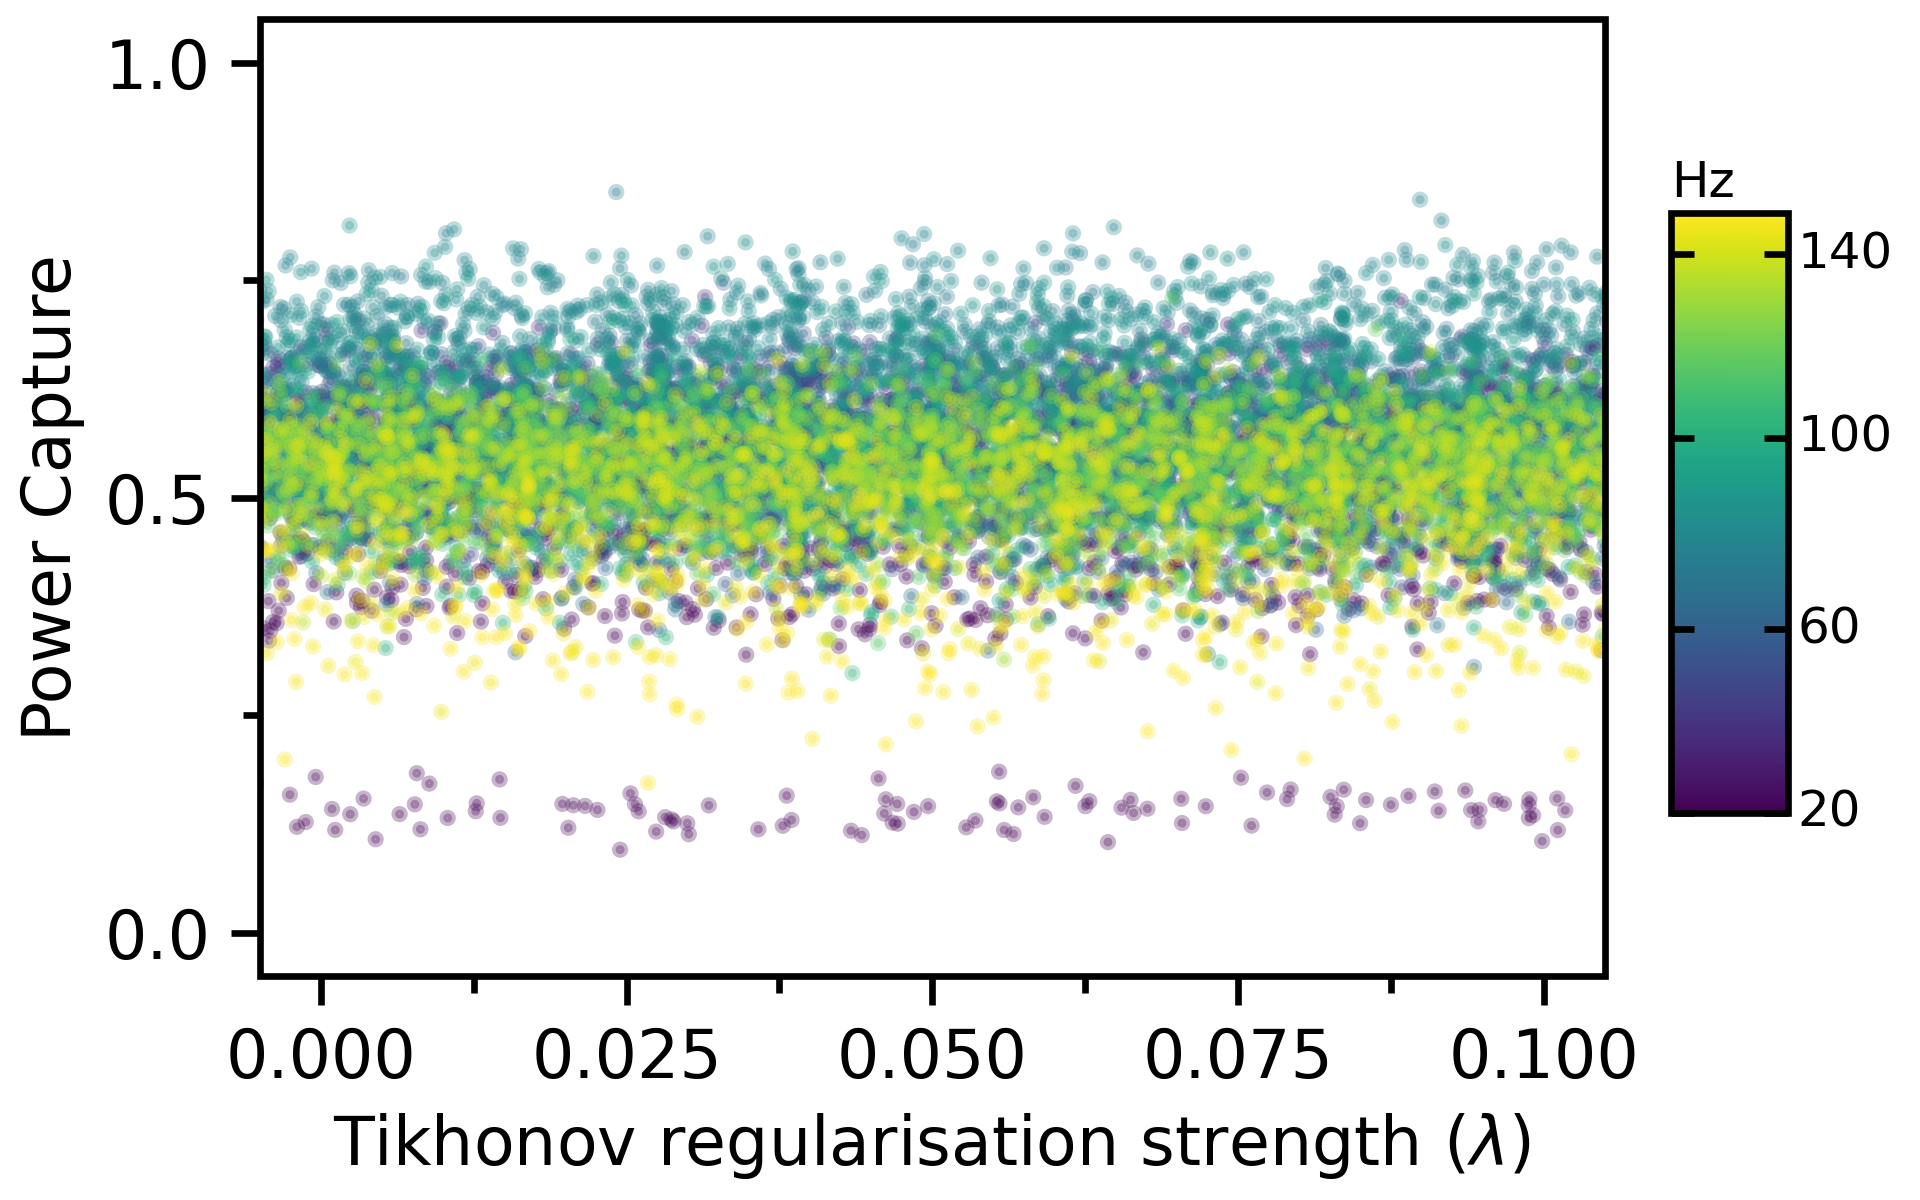

/root/venv/lib/python3.12/site-packages/plotnine/ggplot.py:630: PlotnineWarning: Saving 3.2 x 2 in image.
/root/venv/lib/python3.12/site-packages/plotnine/ggplot.py:631: PlotnineWarning: Filename: /workspace/output/figures/omt_signal_power_capture_lambda_sweep.png
/root/venv/lib/python3.12/site-packages/plotnine/ggplot.py:630: PlotnineWarning: Saving 3.2 x 2 in image.
/root/venv/lib/python3.12/site-packages/plotnine/ggplot.py:631: PlotnineWarning: Filename: /workspace/output/figures/omt_signal_power_capture_lambda_sweep.pdf


In [139]:
# Assuming power_capture_results is a list of tuples: (frequency_index, lambda_reg, frequency, power)
df = pl.DataFrame(lambda_sens, schema=["sample", "lambda_reg", "frequency", "power_capture"], orient="row")

plot = (
    p9.ggplot(df, p9.aes(x="lambda_reg", y="power_capture", fill="frequency", color="frequency"))
    + p9.geom_jitter(width=0.006, alpha=0.3, size=0.1)
    + p9.coord_cartesian(xlim=(1e-8, 1e-1), ylim=(0, 1.0))
    + p9.labs(
        x=r"Tikhonov regularisation strength ($\lambda$)",
        y="Power Capture",
        color="Hz",
    )
    + p9.scale_y_continuous(breaks=np.linspace(0, 1, 3))
    + p9.scale_color_continuous(breaks=np.arange(20, 151, 40))
    + p9.guides(fill=False)
    + p9.theme_matplotlib()
    + p9.theme(
        figure_size=(3.2, 2),
        dpi=300,
        text=p9.element_text(size=8),
        legend_text=p9.element_text(size=6),
        legend_title=p9.element_text(size=6),
        legend_key_size=10
    )
)
plot.show()
plot.save("/workspace/output/figures/omt_signal_power_capture_lambda_sweep.png")
plot.save("/workspace/output/figures/omt_signal_power_capture_lambda_sweep.pdf")

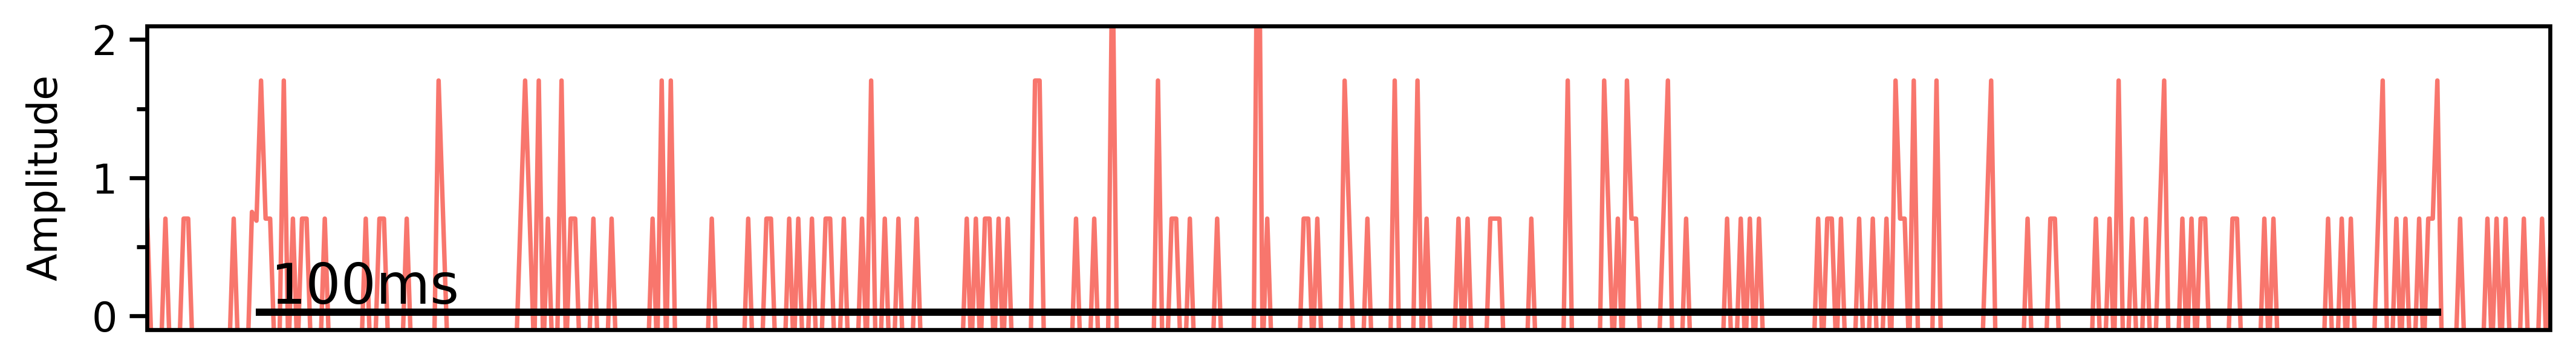

/root/venv/lib/python3.12/site-packages/plotnine/ggplot.py:630: PlotnineWarning: Saving 7.1 x 1.0 in image.
/root/venv/lib/python3.12/site-packages/plotnine/ggplot.py:631: PlotnineWarning: Filename: /workspace/output/figures/omt_signal_deconvolution.png
/root/venv/lib/python3.12/site-packages/plotnine/ggplot.py:630: PlotnineWarning: Saving 7.1 x 1.0 in image.
/root/venv/lib/python3.12/site-packages/plotnine/ggplot.py:631: PlotnineWarning: Filename: /workspace/output/figures/omt_signal_deconvolution.pdf


In [140]:
# draw a graph for the deconvoluted signal

omt_signal = np.zeros_like(t)
rate = 80
t_kernel = np.arange(0, 0.05, 1/fs)
kernel = normalised_twitch_kernel(t_kernel, tau)
for _ in range(N):
    isi = np.random.normal(1/rate, 0.001, size=int(rate * duration * 2))
    spike_times = np.cumsum(isi)
    spike_times = spike_times[spike_times < duration]
    spike_train = np.zeros_like(t)
    spike_idx = (spike_times * fs).astype(int)
    spike_train[spike_idx] = 1

    response = convolve(spike_train, kernel, mode="same")
    omt_signal += response

# --- Zero-padding for FFT ---
n_fft = 2 ** int(np.ceil(np.log2(len(omt_signal))))
omt_signal_padded = np.pad(omt_signal, (0, n_fft - len(omt_signal)))
kernel_padded = np.zeros_like(omt_signal_padded)
kernel_padded[:len(kernel)] = kernel

# --- Frequency domain deconvolution ---
Y = fft(omt_signal_padded)
H = fft(kernel_padded)
H_conj = np.conj(H)
S_hat_tikhonov = (H_conj / (H_conj * H + tikhonov_lambda)) * Y
s_deconv = np.real(ifft(S_hat_tikhonov))
s_deconv = s_deconv[:len(t)]  # Truncate to original length
s_deconv -= s_deconv.mean()   # Remove DC offset

# Create DataFrame for deconvoluted signal
# --- Create Polars DataFrame ---
df_omt = pl.DataFrame({
    "time": t,
    "value": omt_signal,
    "type": "Original OMT"
})

df_deconv = pl.DataFrame({
    "time": t,
    "value": s_deconv,
    "type": "Deconvoluted Signal"
})

df_plot = pl.concat([df_omt, df_deconv])

# # Plot the deconvoluted signal
fig_deconv = (
    p9.ggplot(df_deconv, p9.aes(x="time", y="value", color="type")) +
    p9.geom_line() +
    p9.annotate("rect", xmin=0.1, xmax=0.2, ymin=0, ymax=0.05, fill="black") +
    p9.annotate("text", x=0.105, y=0.2, ha="center", label="100ms") +
    p9.labs(x=False, y="Amplitude") +
    p9.scale_y_continuous(breaks=np.linspace(-2, 2, 5)) +
    p9.coord_cartesian(xlim=(0.1, 0.2), ylim=(0, 2)) +
    p9.theme_matplotlib() +
    p9.guides(color=False, alpha=False) +
    p9.theme(
        figure_size=(7.1, 1.0),
        dpi=300,
        text=p9.element_text(size=8),
        axis_ticks_x=p9.element_blank(),
        axis_text_x=p9.element_blank(),
    )
)
fig_deconv.show()
fig_deconv.save("/workspace/output/figures/omt_signal_deconvolution.png")
fig_deconv.save("/workspace/output/figures/omt_signal_deconvolution.pdf")

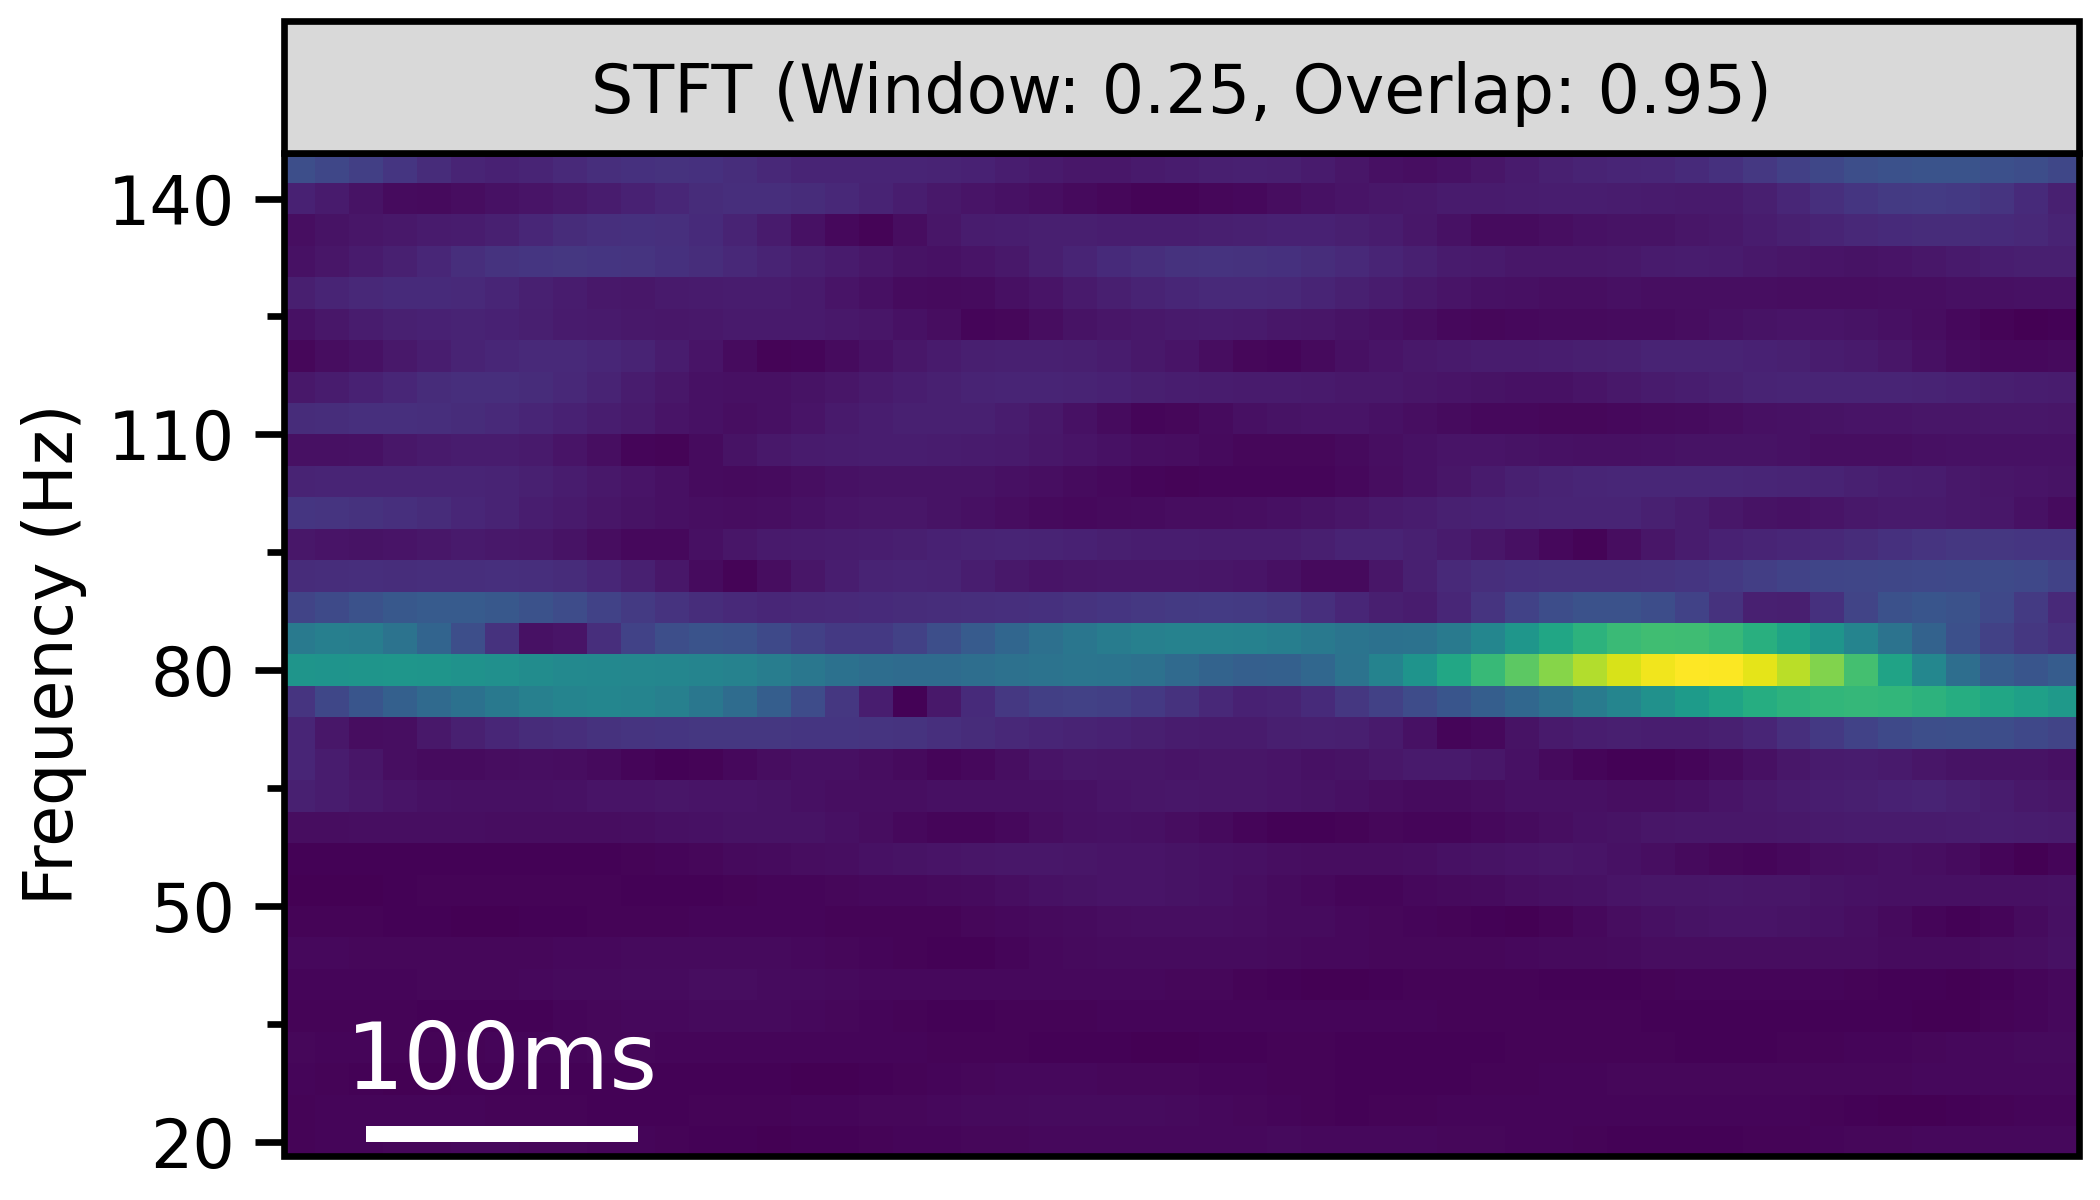

/root/venv/lib/python3.12/site-packages/plotnine/ggplot.py:630: PlotnineWarning: Saving 3.5 x 2 in image.
/root/venv/lib/python3.12/site-packages/plotnine/ggplot.py:631: PlotnineWarning: Filename: /workspace/output/figures/omt_signal_stft_deconvolution.png
/root/venv/lib/python3.12/site-packages/plotnine/ggplot.py:630: PlotnineWarning: Saving 3.5 x 2 in image.
/root/venv/lib/python3.12/site-packages/plotnine/ggplot.py:631: PlotnineWarning: Filename: /workspace/output/figures/omt_signal_stft_deconvolution.pdf


In [141]:
# plot the stft of teh devonvoluted signal
from scipy.signal import stft
nperseg = fs/4
overlap_frac = 0.95
f, t_stft, Zxx = stft(s_deconv.flatten(), fs=fs, nperseg=nperseg, noverlap=int(nperseg * overlap_frac), boundary=None)
stft_df = pl.DataFrame({
    "frequency": np.tile(f, len(t_stft)),
    "time": np.repeat(t_stft, len(f)),
    "magnitude": np.abs(Zxx.T.flatten()),
    "type": f"STFT (Window: {(nperseg/fs):.2f}, Overlap: {overlap_frac:.2f})"
}).filter(
    pl.col("frequency").is_between(20, 150)
)
stft_fig_deconv = (
    p9.ggplot(stft_df, p9.aes(x="time", y="frequency", fill="magnitude")) +
    p9.geom_tile() +
    p9.facet_wrap("~type", scales="free_y") +
    p9.annotate("rect", xmin=0.2, xmax=0.3, ymin=20, ymax=22, fill="white") +
    p9.annotate("text", x=0.25, y=30, label="100ms", ha="center", color="white") +
    p9.labs(x=False, y="Frequency (Hz)", fill="Magnitude (dB)") +
    p9.scale_y_continuous(breaks=np.arange(20, 151, 30)) +
    p9.coord_cartesian(xlim=(0.2, 0.8), ylim=(24, 140)) +
    p9.guides(fill=False) +
    p9.theme_matplotlib() +
    p9.theme(
        figure_size=(3.5, 2),
        dpi=300,
        text=p9.element_text(size=8),
        axis_ticks_x=p9.element_blank(),
        axis_text_x=p9.element_blank()
    )
)
stft_fig_deconv.show()
stft_fig_deconv.save("/workspace/output/figures/omt_signal_stft_deconvolution.png")
stft_fig_deconv.save("/workspace/output/figures/omt_signal_stft_deconvolution.pdf")